# F1 Prediction


The FIA Formula 1 World Championship, better known as Formula 1, F1 or Formula One, is the premier international motorsport competition and the most popular and prestigious motorsport championship in the world since 1950. The governing body is the Fédération Internationale de l'Automobile (FIA). Since September 2016, following the acquisition of Formula One Group, the American company Liberty Media has been responsible for managing and operating the championship.

The objective of this work is to carry out an analysis of the data collected from Formula 1 with the intention of making a predictive model about, for example, the winner of the Grand Prix or the podium.


In [1]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, make_scorer
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from pygad import GA

from optuna import logging, create_study
from optuna.visualization.matplotlib import plot_optimization_history

logging.set_verbosity(logging.WARNING)

from custom_cvs import VariableTimeSeriesSplit
from custom_scorers import (
    balanced_accuracy_score,
    balanced_accuracy_1interval_score,
    mean_absolute_1interval_error,
)

from datetime import datetime
import sys
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Data Selection


The main source of data is from kaggle, specifically,

_Source: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020_

From these data, the datasets used are as follows

- results.csv
- drivers.csv
- constructors.csv
- races.csv
- circuits.csv
- status.csv
- driver_standings.csv
- constructor_standings.csv
- qualifying.csv

Therefore, the ones that remain unused are

- constructor_results.csv
- lap_times.csv
- pit_stops.csv
- seasons.csv
- sprint_results.csv

These data have been omitted either because they are not seen to be useful or are attributes that are acquired at the end of the race, i.e., they could be objective attributes.

Obviously, if the trained model is poor, such unused data sets will be revisited or, in other case, simply look for other data apart from kaggle.


In [2]:
results_df = pd.read_csv("./data/results.csv")
drivers_df = pd.read_csv("./data/drivers.csv")
constructors_df = pd.read_csv("./data/constructors.csv")
races_df = pd.read_csv("./data/races.csv")
circuits_df = pd.read_csv("./data/circuits.csv")
status_df = pd.read_csv("./data/status.csv")
driver_standings_df = pd.read_csv("./data/driver_standings.csv")
constructor_standings_df = pd.read_csv("./data/constructor_standings.csv")
qualifyings_df = pd.read_csv("./data/qualifying.csv")

df = pd.merge(results_df, drivers_df, how="left", on="driverId")
df = df.merge(constructors_df, how="left", on="constructorId")
df = df.merge(races_df, how="left", on="raceId")
df = df.merge(circuits_df, how="left", on="circuitId", suffixes=("", "_z"))
df = df.merge(status_df, how="left", on="statusId")
df = df.merge(driver_standings_df, how="left", on=["raceId", "driverId"])
df = df.merge(constructor_standings_df, how="left", on=["raceId", "constructorId"])
df = df.merge(
    qualifyings_df,
    how="left",
    on=["raceId", "driverId", "constructorId"],
    suffixes=("", "_u"),
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 72 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   resultId                26080 non-null  int64  
 1   raceId                  26080 non-null  int64  
 2   driverId                26080 non-null  int64  
 3   constructorId           26080 non-null  int64  
 4   number_x                26080 non-null  object 
 5   grid                    26080 non-null  int64  
 6   position_x              26080 non-null  object 
 7   positionText_x          26080 non-null  object 
 8   positionOrder           26080 non-null  int64  
 9   points_x                26080 non-null  float64
 10  laps                    26080 non-null  int64  
 11  time_x                  26080 non-null  object 
 12  milliseconds            26080 non-null  object 
 13  fastestLap              26080 non-null  object 
 14  rank                    26080 non-null

Once the datasets have been merged, repeated or useless attributes, such as identifiers, are eliminated. In addition, some of the attributes will be renamed to facilitate compression.


In [3]:
df = df.drop(
    [
        "resultId",
        "position_x",
        "positionText_x",
        "time_x",
        "driverId",
        "code",
        "forename",
        "surname",
        "url_x",
        "constructorId",
        "name_x",
        "url_y",
        "raceId",
        "url",
        "fp1_date",
        "fp1_time",
        "fp2_date",
        "fp2_time",
        "fp3_date",
        "fp3_time",
        "quali_date",
        "quali_time",
        "sprint_date",
        "sprint_time",
        "circuitId",
        "name",
        "url_z",
        "statusId",
        "driverStandingsId",
        "points_y",
        "position_y",
        "positionText_y",
        "constructorStandingsId",
        "positionText",
        "qualifyId",
        "number",
        "position_u",
    ],
    axis=1,
)

col_name = {
    "number_x": "carNumber",
    "grid": "positionGrid",
    "positionOrder": "positionFinal",
    "points_x": "pointsDriverEarned",
    "laps": "lapsCompleted",
    "milliseconds": "timeTakenInMillisec",
    "rank": "fastestLapRank",
    "fastestLapSpeed": "maxSpeed",
    "statusId": "status",
    "number_y": "driverNumber",
    "dob": "driverBirth",
    "nationality_x": "driverNationality",
    "nationality_y": "constructorNationality",
    "year": "raceYear",
    "round": "raceRound",
    "name_y": "grandPrix",
    "date": "raceDate",
    "time_y": "raceTime",
    "location": "circuitLocation",
    "country": "circuitCountry",
    "lat": "circuitLat",
    "lng": "circuitLng",
    "alt": "circuitAlt",
    "status": "driverStatus",
    "wins_x": "driverWins",
    "wins_y": "constructorWins",
    "points": "pointsConstructorEarned",
    "position": "constructorPosition",
}

df.rename(columns=col_name, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carNumber                26080 non-null  object 
 1   positionGrid             26080 non-null  int64  
 2   positionFinal            26080 non-null  int64  
 3   pointsDriverEarned       26080 non-null  float64
 4   lapsCompleted            26080 non-null  int64  
 5   timeTakenInMillisec      26080 non-null  object 
 6   fastestLap               26080 non-null  object 
 7   fastestLapRank           26080 non-null  object 
 8   fastestLapTime           26080 non-null  object 
 9   maxSpeed                 26080 non-null  object 
 10  driverRef                26080 non-null  object 
 11  driverNumber             26080 non-null  object 
 12  driverBirth              26080 non-null  object 
 13  driverNationality        26080 non-null  object 
 14  constructorRef        

## Data Transformation


Each data will be transformed to its corresponding data type. In addition, the times will be converted to milliseconds and two derived attributes will be created: the age of the current driver and when the race was run. Also, the string "\N" will be replaced by None, to determine the nulls in the object type data.


In [4]:
dates = ["driverBirth", "raceDate"]
for d in dates:
    df[d] = pd.to_datetime(df[d])

h_f, m_f = "%H:%M:%S", "%M:%S.%f"
times = [
    ("fastestLapTime", m_f),
    ("raceTime", h_f),
    ("q1", m_f),
    ("q2", m_f),
    ("q3", m_f),
]
for t, f in times:
    df[t] = pd.to_numeric(
        pd.to_timedelta(
            pd.to_datetime(df[t], format=f, errors="coerce").dt.time.to_numpy(dtype=str)
        ).total_seconds()
        * 1000
    )

numbers = [
    "carNumber",
    "positionGrid",
    "positionFinal",
    "pointsDriverEarned",
    "lapsCompleted",
    "timeTakenInMillisec",
    "fastestLap",
    "fastestLapRank",
    "maxSpeed",
    "driverNumber",
    "raceYear",
    "raceRound",
    "circuitLat",
    "circuitLng",
    "circuitAlt",
    "driverWins",
    "pointsConstructorEarned",
    "constructorPosition",
    "constructorWins",
]
for n in numbers:
    df[n] = pd.to_numeric(df[n], errors="coerce")

df["driverAgeToday"] = datetime.today().year - df["driverBirth"].dt.year
df["driverAgeAtRace"] = df["raceDate"].dt.year - df["driverBirth"].dt.year
df = df.drop(["driverBirth"], axis=1)
df = df.drop(["raceDate"], axis=1)

df = df.replace("\\N", None)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26080 entries, 0 to 26079
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   carNumber                26074 non-null  float64
 1   positionGrid             26080 non-null  int64  
 2   positionFinal            26080 non-null  int64  
 3   pointsDriverEarned       26080 non-null  float64
 4   lapsCompleted            26080 non-null  int64  
 5   timeTakenInMillisec      7250 non-null   float64
 6   fastestLap               7615 non-null   float64
 7   fastestLapRank           7831 non-null   float64
 8   fastestLapTime           7615 non-null   float64
 9   maxSpeed                 7615 non-null   float64
 10  driverRef                26080 non-null  object 
 11  driverNumber             5823 non-null   float64
 12  driverNationality        26080 non-null  object 
 13  constructorRef           26080 non-null  object 
 14  constructorNationality

## Missing Values


First, we will check the number of nulls in each column.


In [5]:
df.isnull().sum()

carNumber                      6
positionGrid                   0
positionFinal                  0
pointsDriverEarned             0
lapsCompleted                  0
timeTakenInMillisec        18830
fastestLap                 18465
fastestLapRank             18249
fastestLapTime             18465
maxSpeed                   18465
driverRef                      0
driverNumber               20257
driverNationality              0
constructorRef                 0
constructorNationality         0
raceYear                       0
raceRound                      0
grandPrix                      0
raceTime                   18469
circuitRef                     0
circuitLocation                0
circuitCountry                 0
circuitLat                     0
circuitLng                     0
circuitAlt                    60
driverStatus                   0
driverWins                   469
pointsConstructorEarned     1867
constructorPosition         1867
constructorWins             1867
q1        

We can see several nulls in several columns, three of them being the qualifying times. Being data that provide great information about how well a driver can be given a circuit days before the grand prix, for the treatment of nulls we can start focusing on these times.

Specifically, there are several nulls, since the currently known qualifiers did not exist until 2006, with minor modifications. Previously, it could be that there were no qualifiers at all, or that there were not all three. For example, see the following link from 2016 for a bit of history of the qualifiers and the grid.

_Source: https://www.formula1.com/en/latest/features/2016/3/deciding-the-grid-a-history-of-f1-qualifying-formats.html_

Likewise, we can see that this is also corroborated in the data.


In [6]:
first_q_not_null = ~(df["q1"].isnull())
second_q_not_null = ~(df["q2"].isnull())
third_q_not_null = ~(df["q3"].isnull())
mask = first_q_not_null & second_q_not_null & third_q_not_null

df[mask]["raceYear"].drop_duplicates().sort_values().to_numpy().reshape(-1, 1)

array([[2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017],
       [2018],
       [2019],
       [2020],
       [2021],
       [2022],
       [2023]], dtype=int64)

Therefore, the model will be limited to training only from 2006 onwards.

Obviously, if we see that the model remains poor, we can change the range and study the behavior of the model.


In [7]:
df = df[df["raceYear"] >= 2006]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                          102
q2      

There are still some nulls, which is normal, since not all pilots run all the qualifying rounds. As the grid position is determined by the lowest possible time of the three qualifiers, it will be sufficient to replicate the times in those qualifiers that are null. If the first two races are run and not the third, one of the other two races will be randomly selected to fill the third.


In [8]:
mask = first_q_not_null & ~second_q_not_null & ~third_q_not_null
df.loc[mask, ["q2", "q3"]] = df.loc[mask, "q1"]

mask = first_q_not_null & second_q_not_null & ~third_q_not_null
df.loc[mask, "q3"] = df.loc[mask, ["q1", "q2"]].sample(axis=1).squeeze()

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                          102
q2      

In the same way, there are still nulls, which will probably be those drivers who for some reason have not been able to run the qualifiers and will start in the last positions.


In [9]:
df[df["q1"].isnull()]["positionGrid"].drop_duplicates().sort_values().values

array([ 0, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

Ignoring the case of the value 0, which will be discussed later, we can see that these are indeed the last positions.

Therefore, the maximum time will be assigned, taking into account that it will be per race and not globally.


In [10]:
qualify_by_race = (
    df[["raceYear", "raceRound", "q1"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"q1": "max"})
)

mask = ~first_q_not_null & ~second_q_not_null & ~third_q_not_null

mg = df.loc[mask]
mg = mg.join(qualify_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, ["q1", "q2", "q3"]] = mg["q1Max"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                   60
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

Once the nulls of the qualifiers have been resolved, we will move on to others.

The case of the grid positions that are 0, are special cases in which the FIA allows drivers who have not qualified to race. For example, in the third grand prix of the 2023 season, perez and bottas were allowed to race without qualifying, as shown in the following link

_Source: https://www.formula1.com/en/results.html/2023/races/1143/australia/starting-grid.html_

We can also see this in the data


In [11]:
race_last_year = df["raceYear"] == 2023
race_round_three = df["raceRound"] == 3
position_grid_zero = df["positionGrid"] == 0
mask = race_last_year & race_round_three & position_grid_zero

df[mask].head()

carNumber  positionGrid  positionFinal  pointsDriverEarned  \
25884       11.0             0              5                11.0   
25890       77.0             0             11                 0.0   

       lapsCompleted  timeTakenInMillisec  fastestLap  fastestLapRank  \
25884             58            9161691.0        53.0             1.0   
25890             58            9164884.0        46.0            17.0   

       fastestLapTime  maxSpeed driverRef  driverNumber driverNationality  \
25884         80235.0   236.814     perez          11.0           Mexican   
25890         82233.0   231.060    bottas          77.0           Finnish   

      constructorRef constructorNationality  raceYear  raceRound  \
25884       red_bull               Austrian      2023          3   
25890           alfa                  Swiss      2023          3   

                   grandPrix    raceTime   circuitRef circuitLocation  \
25884  Australian Grand Prix  18000000.0  albert_park       Melbourne   
25890  Australian Grand Prix  18000000.0  albert_park       Melbourne   

      circuitCountry  circuitLat  circuitLng  circuitAlt driverStatus  \
25884      Australia    -37.8497     144.968        10.0     Finished   
25890      Australia    -37.8497     144.968        10.0     Finished   

       driverWins  pointsConstructorEarned  constructorPosition  \
25884         1.0                    123.0                  1.0   
25890         0.0                      6.0                  8.0   

       constructorWins       q1       q2       q3  driverAgeToday  \
25884              3.0  78714.0  78714.0  78714.0              34   
25890              0.0  78714.0  78714.0  78714.0              35   

       driverAgeAtRace  
25884               33  
25890               34

Then, as it is not known in which grid position they started, we will put the last positions.


In [12]:
last_grid_by_race = (
    df[["raceYear", "raceRound", "positionGrid"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"positionGrid": lambda x: max(x) + 1})
)

mask = position_grid_zero
mg = df[mask]
mg = mg.join(last_grid_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, "positionGrid"] = mg["positionGridMax"]

df["positionGrid"].drop_duplicates().sort_values().to_numpy()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Regarding the circuits, we are missing information on the altitude of the following circuits


In [13]:
df[df["circuitAlt"].isnull()]["circuitRef"].drop_duplicates()

25340    losail
25480     miami
Name: circuitRef, dtype: object

Simply look up the altitude of these two circuits manually and enter them into the data set.


In [14]:
df.loc[df["circuitRef"] == "losail", "circuitAlt"] = 20
df.loc[df["circuitRef"] == "miami", "circuitAlt"] = 2

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                   51
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

To solve the number of victories of the pilots, knowing that they are per season, i.e., they start at 0 per year, it is simple to calculate the nulls.


In [15]:
df = df.sort_values(by=["raceYear", "driverRef", "raceRound"]).reset_index(drop=True)

drivers = df[df["driverWins"].isnull()]["driverRef"].drop_duplicates().to_numpy()
j = df.columns.get_loc("driverWins")

for driver in drivers:
    mask = (df["driverRef"] == driver) & (df["driverWins"].isnull())
    indexes = df[mask].index
    for i in indexes:
        pdata, cdata = df.iloc[i - 1], df.iloc[i]
        if (
            pdata["driverRef"] != cdata["driverRef"]
            or pdata["raceYear"] != cdata["raceYear"]
        ):
            if cdata["positionFinal"] == 1:
                df.iloc[i, j] = 1
            else:
                df.iloc[i, j] = 0
        else:
            if cdata["positionFinal"] == 1:
                df.iloc[i, j] = pdata["driverWins"] + 1
            else:
                df.iloc[i, j] = pdata["driverWins"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned      18
constructorPosition          18
constructorWins              18
q1                            0
q2      

Regarding the three nulls related to the constructors, since they are a little more difficult to calculate, and since there are few of them, we will first study them manually.


In [16]:
proyection = [
    "raceYear",
    "raceRound",
    "constructorRef",
    "constructorWins",
    "pointsConstructorEarned",
    "constructorPosition",
    "driverRef",
    "driverStatus",
]

nulls = df[df["pointsConstructorEarned"].isnull()]
nulls.sort_values(by=["raceYear", "raceRound", "constructorRef"])[proyection]

raceYear  raceRound constructorRef  constructorWins  \
864       2008          1    force_india              NaN   
1066      2008          1    force_india              NaN   
788       2008          1          honda              NaN   
824       2008          1          honda              NaN   
842       2008          1       red_bull              NaN   
1120      2008          1       red_bull              NaN   
860       2008          1    super_aguri              NaN   
1062      2008          1    super_aguri              NaN   
882       2008          1         toyota              NaN   
1084      2008          1         toyota              NaN   
1264      2009          1        mclaren              NaN   
1300      2009          1        mclaren              NaN   
2106      2011          1            hrt              NaN   
2153      2011          1            hrt              NaN   
2115      2011          1         sauber              NaN   
2228      2011          1         sauber              NaN   
2530      2012          1            hrt              NaN   
2770      2012          1            hrt              NaN   

      pointsConstructorEarned  constructorPosition    driverRef  \
864                       NaN                  NaN   fisichella   
1066                      NaN                  NaN        sutil   
788                       NaN                  NaN  barrichello   
824                       NaN                  NaN       button   
842                       NaN                  NaN    coulthard   
1120                      NaN                  NaN       webber   
860                       NaN                  NaN     davidson   
1062                      NaN                  NaN         sato   
882                       NaN                  NaN        glock   
1084                      NaN                  NaN       trulli   
1264                      NaN                  NaN     hamilton   
1300                      NaN                  NaN   kovalainen   
2106                      NaN                  NaN  karthikeyan   
2153                      NaN                  NaN       liuzzi   
2115                      NaN                  NaN    kobayashi   
2228                      NaN                  NaN        perez   
2530                      NaN                  NaN  karthikeyan   
2770                      NaN                  NaN         rosa   

         driverStatus  
864         Collision  
1066       Hydraulics  
788      Disqualified  
824         Collision  
842         Collision  
1120        Collision  
860         Collision  
1062     Transmission  
882          Accident  
1084       Electrical  
1264     Disqualified  
1300        Collision  
2106  Did not qualify  
2153  Did not qualify  
2115     Disqualified  
2228     Disqualified  
2530  Did not qualify  
2770  Did not qualify

It can be seen that they have no wins or points as these are the first races of the seasons where the two drivers of the same constructor have not been able to finish the race. Therefore, for these two attributes will be filled with zeros.

Regarding the position, each constructor will be provided with the maximum, obviously, per race.


In [17]:
mask = ["constructorWins", "pointsConstructorEarned"]
df[mask] = df[mask].fillna(0)

last_ctor_by_race = (
    df[["raceYear", "raceRound", "constructorPosition"]]
    .groupby(["raceYear", "raceRound"])
    .agg({"constructorPosition": lambda x: max(x) + 1})
)


mask = df["constructorPosition"].isnull()


mg = df[mask]
mg = mg.join(last_ctor_by_race, how="left", on=["raceYear", "raceRound"], rsuffix="Max")
df.loc[mask, "constructorPosition"] = mg["constructorPositionMax"]

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber               1724
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned       0
constructorPosition           0
constructorWins               0
q1                            0
q2      

Finally, the driver numbers have yet to be specified. First we will see which are the drivers without numbers.


In [18]:
df[df["driverNumber"].isnull()]["driverRef"].drop_duplicates().to_numpy()

array(['albers', 'barrichello', 'coulthard', 'doornbos', 'fisichella',
       'heidfeld', 'ide', 'klien', 'liuzzi', 'michael_schumacher',
       'montagny', 'monteiro', 'montoya', 'ralf_schumacher', 'rosa',
       'sato', 'speed', 'trulli', 'villeneuve', 'webber', 'yamamoto',
       'davidson', 'kovalainen', 'markus_winkelhock', 'nakajima', 'wurz',
       'bourdais', 'glock', 'piquet_jr', 'alguersuari', 'badoer', 'buemi',
       'bruno_senna', 'chandhok', 'grassi', 'petrov', 'ambrosio',
       'karthikeyan', 'resta', 'pic', 'garde'], dtype=object)

Doing a little research, it's not just that these pilots are not numbered in the data set, but that they can't be found on the web either. For example, in the following link there is a compilation of numbers in which none appears.

_Source: https://en.wikipedia.org/wiki/List_of_Formula_One_driver_numbers_

For this reason, and bearing in mind that the numbers should not significantly influence the result, they will be provided with a possible random number, i.e., one that is in the range 2 to 99 without the 17, and, obviously, not already in use.


In [19]:
numbers = np.arange(2, 100, dtype=np.float64)
numbers = np.delete(numbers, np.where(numbers == 17.0))
numbers_by_year = {
    year: np.delete(
        numbers,
        np.where(np.isin(numbers, df["driverNumber"].drop_duplicates())),
    ).tolist()
    for year in df["raceYear"].drop_duplicates()
}

drivers = df[df["driverNumber"].isnull()]["driverRef"].drop_duplicates().to_numpy()

for driver in drivers:
    mask = df["driverRef"] == driver
    first_year = df.loc[mask, "raceYear"].head(1).values[0]
    last_year = df.loc[mask, "raceYear"].tail(1).values[0]
    possible_numbers = numbers_by_year[first_year]
    driver_number = np.random.choice(possible_numbers, 1)[0]
    df.loc[mask, "driverNumber"] = driver_number
    while first_year <= last_year:
        ls = numbers_by_year[first_year]
        new_possible_numbers = np.delete(ls, np.where(ls == driver_number))
        numbers_by_year[first_year] = new_possible_numbers
        first_year += 1

df.isnull().sum()

carNumber                     0
positionGrid                  0
positionFinal                 0
pointsDriverEarned            0
lapsCompleted                 0
timeTakenInMillisec        3654
fastestLap                  321
fastestLapRank              105
fastestLapTime              321
maxSpeed                    321
driverRef                     0
driverNumber                  0
driverNationality             0
constructorRef                0
constructorNationality        0
raceYear                      0
raceRound                     0
grandPrix                     0
raceTime                      0
circuitRef                    0
circuitLocation               0
circuitCountry                0
circuitLat                    0
circuitLng                    0
circuitAlt                    0
driverStatus                  0
driverWins                    0
pointsConstructorEarned       0
constructorPosition           0
constructorWins               0
q1                            0
q2      

Finally, there are attributes that are known once the race is over, i.e., possible target attributes. As they will not be used for now, they will be left unprocessed, with a possible revision in the future if we need to add more attributes to improve the model or change prediction.


## Model Validation


For the validation of the model, it will be tested with different target attributes, specifically

- Final position of the driver
- Final position of the driver in a +-1 interval
- Final position of the driver in fixed intervals of size 3
- The driver is winner or not
- The driver is podium or not

In any case, we will first have to order the instances to carry out the training of the model.


In [20]:
df = df.sort_values(by=["raceYear", "raceRound"]).reset_index(drop=True)

On the other hand, training will be done with walkforward, whose scikit instance that implements it is TimeSeriesSplit.


In [21]:
X_tscv = pd.DataFrame([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
tscv = TimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


However, the time intervals offered by TimeSeriesSplit are fixed, i.e. there cannot be more instances in one interval than in another. In our case, we have that every F1 season there can be more or less instances due to the variation of the drivers as well as the number of races. This can be seen below


In [22]:
instances_per_year = df["raceYear"].value_counts(sort=False)
instances_per_year

raceYear
2006    396
2007    374
2008    368
2009    340
2010    456
2011    456
2012    480
2013    418
2014    407
2015    378
2016    462
2017    400
2018    420
2019    420
2020    340
2021    440
2022    440
2023    240
Name: count, dtype: int64

Therefore, another class has been created extending TimeSeriesSplit that allows the variation of instances in each of the intervals, VariableTimeSeriesSplit. It has been created in an external file so as not to dirty the notebook.

First, let's see that the behavior is the same with the same parameters called above with TimeSeriesSplit.


In [23]:
tscv = VariableTimeSeriesSplit(n_splits=2, max_train_size=3, test_size=1)

for train, test in tscv.split(X_tscv):
    print("%s %s" % (train, test))

[1 2 3] [4]
[2 3 4] [5]


Now we will check the case of F1 seasons. Notice that half-seasons will be considered instead of full seasons.


In [24]:
instances_per_half = (
    np.array(
        list(zip(np.floor(instances_per_year / 2), np.ceil(instances_per_year / 2)))
    )
    .flatten()
    .astype(np.int32)
)
instances_per_half

array([198, 198, 187, 187, 184, 184, 170, 170, 228, 228, 228, 228, 240,
       240, 209, 209, 203, 204, 189, 189, 231, 231, 200, 200, 210, 210,
       210, 210, 170, 170, 220, 220, 220, 220, 120, 120])

In [25]:
n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

get_years = lambda x: ",".join(
    df.iloc[x]["raceYear"].drop_duplicates().to_numpy(dtype=str)
)

for i, (tr, ts) in enumerate(tscv.split(df)):
    print(f"Split {i+1}-th:")
    print(f"-> Train years (from {tr[0]} to {tr[len(tr)-1]}): {get_years(tr)}")
    print(f"-> Test years (from {ts[0]} to {ts[len(ts)-1]}): {get_years(ts)}")
    print()

Split 1-th:
-> Train years (from 0 to 1933): 2006,2007,2008,2009,2010
-> Test years (from 1934 to 2161): 2011

Split 2-th:
-> Train years (from 198 to 2161): 2006,2007,2008,2009,2010,2011
-> Test years (from 2162 to 2389): 2011

Split 3-th:
-> Train years (from 396 to 2389): 2007,2008,2009,2010,2011
-> Test years (from 2390 to 2629): 2012

Split 4-th:
-> Train years (from 583 to 2629): 2007,2008,2009,2010,2011,2012
-> Test years (from 2630 to 2869): 2012

Split 5-th:
-> Train years (from 770 to 2869): 2008,2009,2010,2011,2012
-> Test years (from 2870 to 3078): 2013

Split 6-th:
-> Train years (from 954 to 3078): 2008,2009,2010,2011,2012,2013
-> Test years (from 3079 to 3287): 2013

Split 7-th:
-> Train years (from 1138 to 3287): 2009,2010,2011,2012,2013
-> Test years (from 3288 to 3490): 2014

Split 8-th:
-> Train years (from 1308 to 3490): 2009,2010,2011,2012,2013,2014
-> Test years (from 3491 to 3694): 2014

Split 9-th:
-> Train years (from 1478 to 3694): 2010,2011,2012,2013,2014
-> 

Finally, before we start training the models with each target attribute, we have to encode the categorical attributes of the dataframe.


In [26]:
X = df.drop(
    [
        "positionFinal",
        "pointsDriverEarned",
        "lapsCompleted",
        "timeTakenInMillisec",
        "fastestLap",
        "fastestLapRank",
        "fastestLapTime",
        "maxSpeed",
        "driverStatus",
        "pointsConstructorEarned",
        "constructorPosition",
    ],
    axis=1,
)

enc = LabelEncoder()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = enc.fit_transform(X[c])

First, we will check if the values are in similar range in order to apply models that depend on normalization.


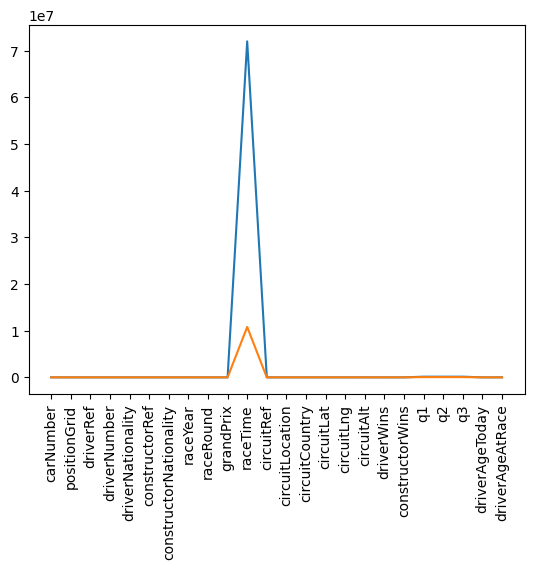

In [27]:
maxs, mins = X.max(), X.min()

ext_inf = 0
ext_sup = len(X.columns)

plt.plot(maxs[ext_inf:ext_sup])
plt.plot(mins[ext_inf:ext_sup])

plt.xticks(ticks=range(ext_sup - ext_inf), labels=X.columns, rotation=90)
plt.show()

We can see that, indeed, we need to normalize the data. For this purpose, RobustScaler will be used since, after some tests, it is the one with which the best results have been obtained and it keeps the outliers separated from the inliers.


In [28]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

Let's look again at the range of values.


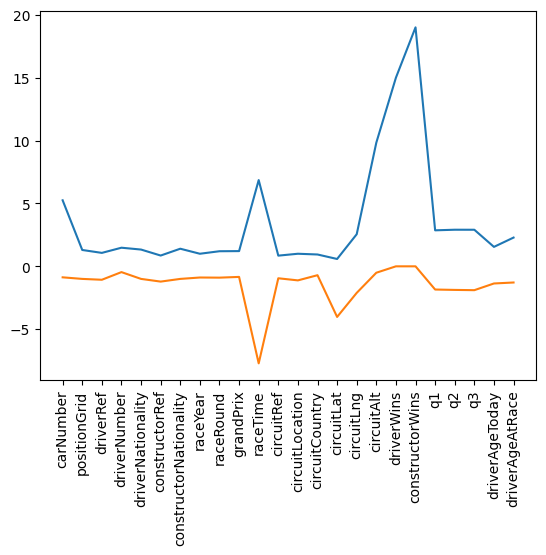

In [29]:
maxs, mins = X.max(), X.min()

ext_inf = 0
ext_sup = len(X.columns)

plt.plot(maxs[ext_inf:ext_sup])
plt.plot(mins[ext_inf:ext_sup])

plt.xticks(ticks=range(ext_sup - ext_inf), labels=X.columns, rotation=90)
plt.show()

Once normalized, we will also create a function to facilitate the testing of the models.


In [30]:
def model_test(
    models,
    X,
    y,
    cv,
    *,
    scorers=[make_scorer(balanced_accuracy_score), "neg_mean_absolute_error"],
    interval=None,
    labels=None,
):

    _, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(15, 6))

    for i, model in enumerate(models):

        print(f"{model}:")

        for scorer in scorers:
            scores = cross_val_score(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)
            print(f"CV with {scorer}:", scores.sum() / len(scores))

        splits = [
            (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])
            for (train, test) in cv.split(X)
        ]

        y_tests, y_preds = np.array([], dtype=np.int32), np.array([], dtype=np.int32)

        for split in splits:
            X_train, X_test, y_train, y_test = split
            model.fit(X_train, y_train)
            y_tests = np.append(y_tests, y_test.values)
            y_preds = np.append(y_preds, np.rint(model.predict(X_test)).astype(int))

        if interval is not None:
            y_preds = np.where(np.abs(y_tests - y_preds) <= interval, y_tests, y_preds)

        if labels is not None:
            y_tests, y_preds = labels[y_tests], labels[y_preds]

        print(classification_report(y_tests, y_preds, labels=labels))

        ax = axes[i] if len(models) > 1 else axes
        ConfusionMatrixDisplay.from_predictions(
            y_tests, y_preds, xticks_rotation="vertical", ax=ax, labels=labels
        )
        ax.title.set_text(type(model).__name__)

    plt.tight_layout()
    plt.show()

The first objective attribute to be addressed will be the final position of each driver.


In [31]:
y = df["positionFinal"]

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=3):


CV with make_scorer(balanced_accuracy_score): 0.10267629676720585
CV with neg_mean_absolute_error: -5.075038286432143
              precision    recall  f1-score   support

           1       0.36      0.63      0.45       252
           2       0.15      0.26      0.19       252
           3       0.10      0.16      0.12       252
           4       0.06      0.08      0.07       252
           5       0.07      0.12      0.08       252
           6       0.06      0.10      0.07       252
           7       0.07      0.12      0.09       252
           8       0.07      0.09      0.08       252
           9       0.06      0.08      0.06       252
          10       0.06      0.08      0.07       252
          11       0.07      0.08      0.08       252
          12       0.08      0.08      0.08       252
          13       0.07      0.05      0.06       252
          14       0.09      0.07      0.08       252
          15       0.07      0.03      0.04       252
          16     

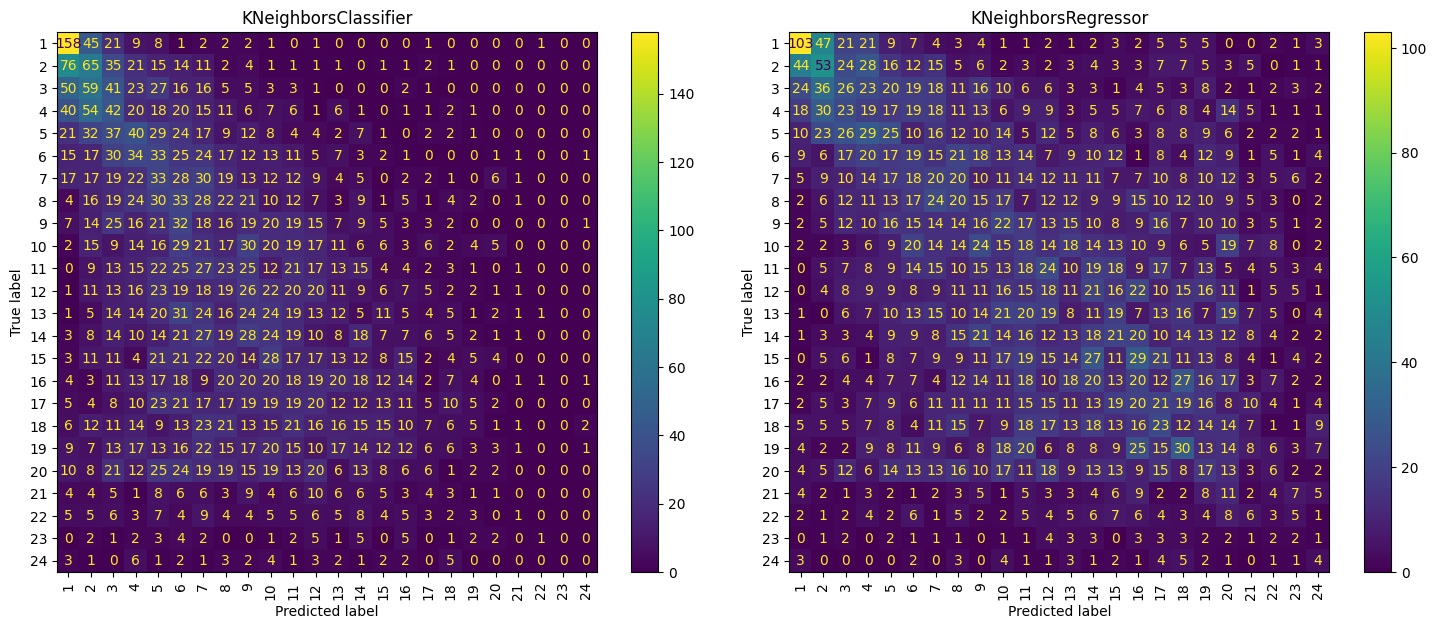

In [32]:
knn = (
    KNeighborsClassifier(n_neighbors=3, metric="euclidean", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=1, metric="euclidean", n_jobs=-1),
)
model_test(knn, X, y, tscv)

DecisionTreeClassifier(criterion='entropy', max_depth=5):
CV with make_scorer(balanced_accuracy_score): 0.13191055367191729
CV with neg_mean_absolute_error: -3.898779592766462
              precision    recall  f1-score   support

           1       0.47      0.71      0.56       252
           2       0.22      0.21      0.22       252
           3       0.17      0.28      0.22       252
           4       0.13      0.19      0.16       252
           5       0.10      0.10      0.10       252
           6       0.14      0.12      0.13       252
           7       0.10      0.17      0.12       252
           8       0.08      0.06      0.07       252
           9       0.09      0.11      0.10       252
          10       0.06      0.04      0.05       252
          11       0.05      0.08      0.06       252
          12       0.08      0.15      0.10       252
          13       0.07      0.07      0.07       252
          14       0.08      0.06      0.07       252
          15 

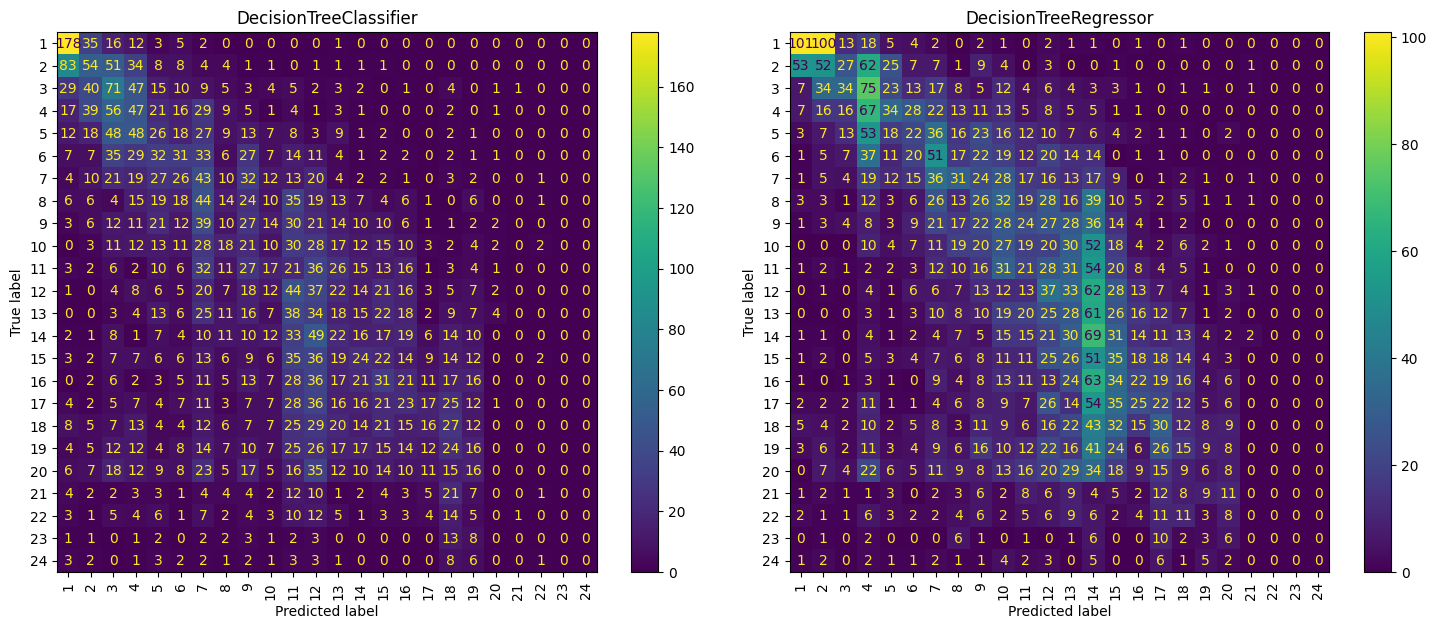

In [33]:
tree = (
    DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    DecisionTreeRegressor(max_depth=4, criterion="absolute_error"),
)
model_test(tree, X, y, tscv)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10,
                       n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.13213907725271362
CV with neg_mean_absolute_error: -4.004248875810342
              precision    recall  f1-score   support

           1       0.35      0.82      0.50       252
           2       0.12      0.11      0.12       252
           3       0.14      0.17      0.16       252
           4       0.14      0.13      0.13       252
           5       0.10      0.10      0.10       252
           6       0.10      0.15      0.12       252
           7       0.13      0.13      0.13       252
           8       0.07      0.04      0.05       252
           9       0.07      0.08      0.08       252
          10       0.06      0.06      0.06       252
          11       0.08      0.08      0.08       252
          12       0.09      0.15      0.12       252
          13       0.07      0.07      0.07       252
          14    

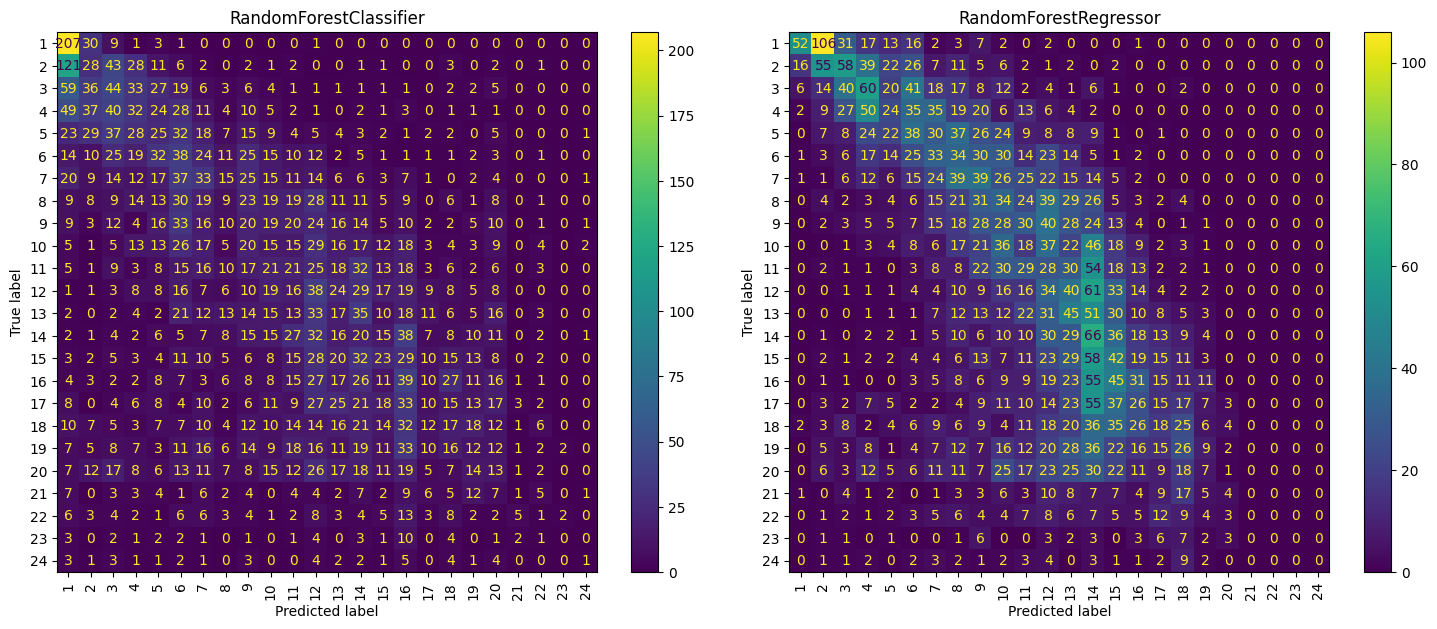

In [34]:
random_forest = (
    RandomForestClassifier(
        n_estimators=10, max_depth=5, criterion="entropy", n_jobs=-1
    ),
    RandomForestRegressor(
        n_estimators=10, max_depth=5, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_score): 0.14267532551623457
CV with neg_mean_absolute_error: -3.654430665125258
              precision    recall  f1-score   support

           1       0.46      0.81      0.59       252
           2       0.20      0.21      0.21       252
           3       0.18      0.17      0.17       252
           4       0.16      0.18      0.17       252
           5       0.12      0.13      0.13       252
           6       0.13      0.22      0.16       252
           7       0.12      0.17      0.14       252
           8       0.09      0.06      0.07       252
           9       0.11      0.10      0.11       252
          10       0.08      0.05      0.06       252
          11       0.07      0.12      0.09       252
          12       0.09      0.11      0.10       252
          13       0.08      0.09      0.08       252
          14       0.08      0.05      0.06       252
    

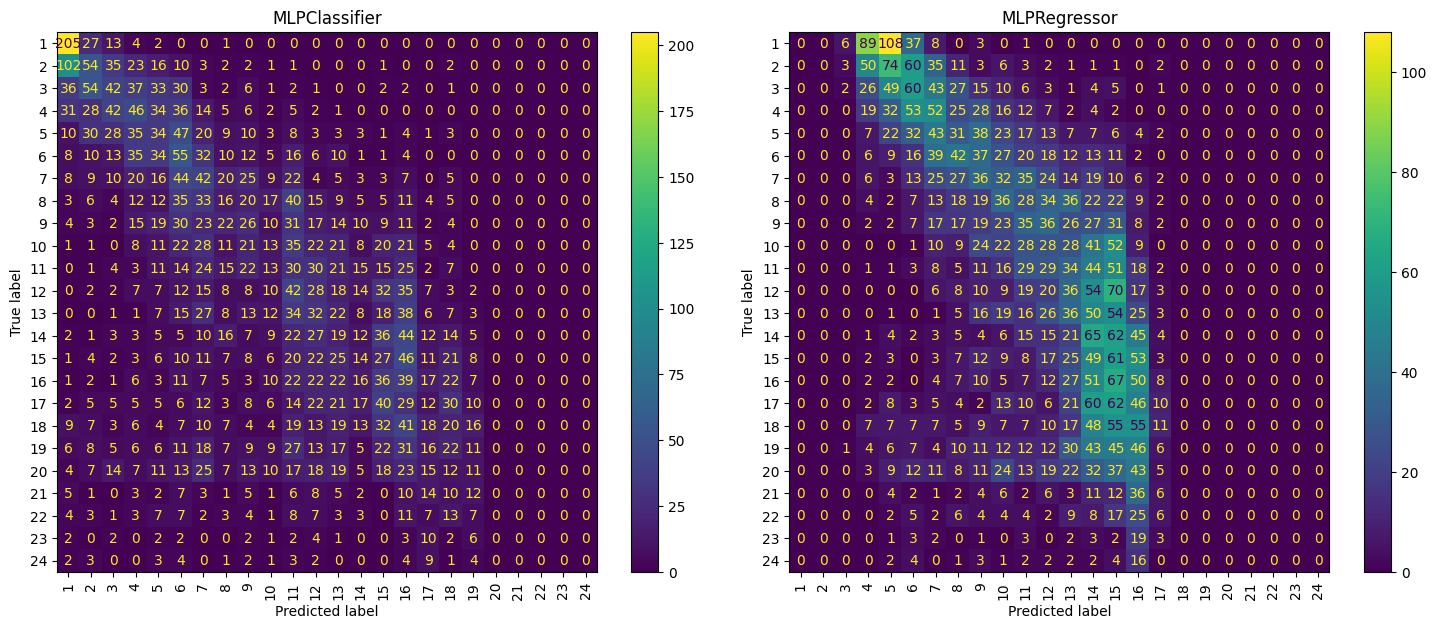

In [35]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv)

The second objective attribute to be addressed will be the final position in a +-1 interval of each driver.


In [36]:
scorers = [
    make_scorer(balanced_accuracy_1interval_score),
    make_scorer(mean_absolute_1interval_error, greater_is_better=False),
]
y = df["positionFinal"]

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=2):
CV with make_scorer(balanced_accuracy_1interval_score): 0.2565018188881825
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -4.67048132738642
              precision    recall  f1-score   support

           1       0.53      0.76      0.62       252
           2       0.45      0.63      0.52       252
           3       0.30      0.44      0.36       252
           4       0.25      0.33      0.28       252
           5       0.22      0.31      0.26       252
           6       0.19      0.29      0.23       252
           7       0.20      0.29      0.23       252
           8       0.20      0.27      0.23       252
           9       0.17      0.21      0.19       252
          10       0.21      0.27      0.24       252
          11       0.19      0.23      0.21       252
          12       0.18      0.20      0.19       252
          13       0.21      0.16      0.18       252
     

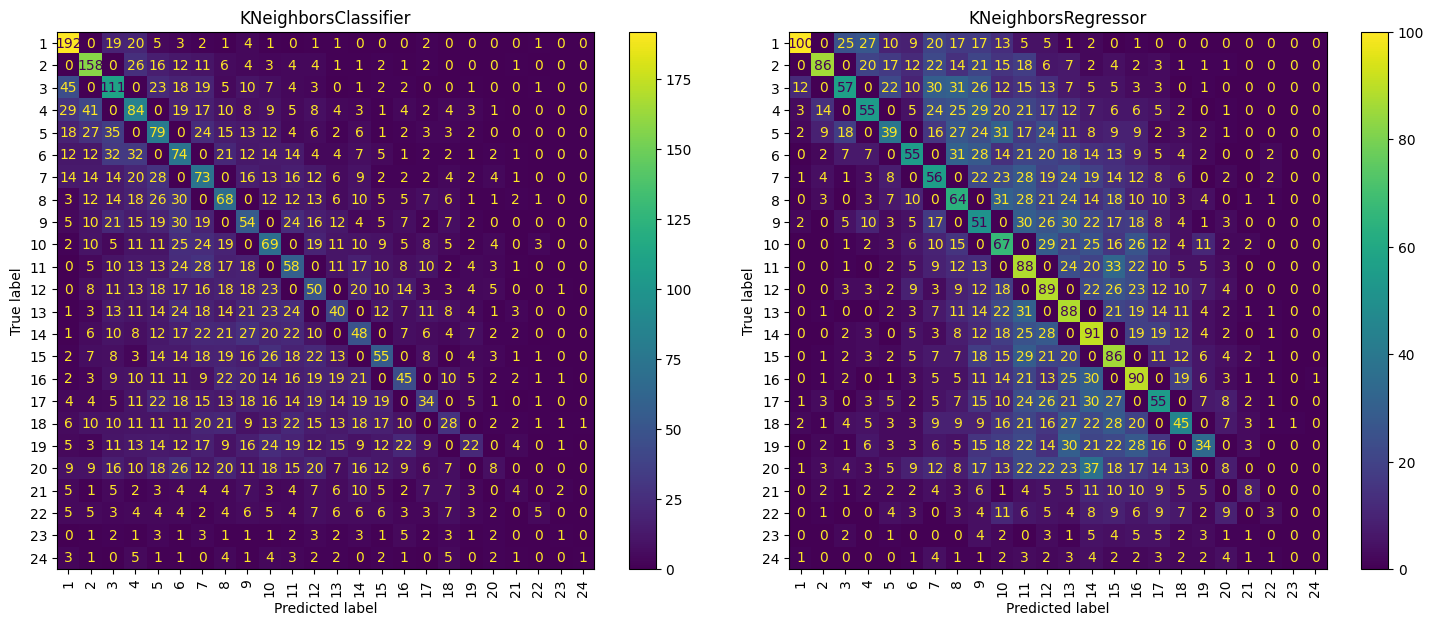

In [37]:
knn = (
    KNeighborsClassifier(n_neighbors=2, metric="euclidean", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=3, metric="euclidean", n_jobs=-1),
)
model_test(knn, X, y, tscv, scorers=scorers, interval=1)

DecisionTreeClassifier(criterion='entropy', max_depth=4):
CV with make_scorer(balanced_accuracy_1interval_score): 0.33781340502931406
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.602214574754609
              precision    recall  f1-score   support

           1       0.62      0.86      0.72       252
           2       0.62      0.77      0.69       252
           3       0.42      0.59      0.49       252
           4       0.38      0.47      0.42       252
           5       0.34      0.34      0.34       252
           6       0.36      0.41      0.38       252
           7       0.22      0.35      0.27       252
           8       0.43      0.32      0.37       252
           9       0.17      0.21      0.19       252
          10       0.50      0.32      0.39       252
          11       0.15      0.29      0.20       252
          12       0.27      0.39      0.32       252
          13       0.25      0.24      0.25       252
          14 

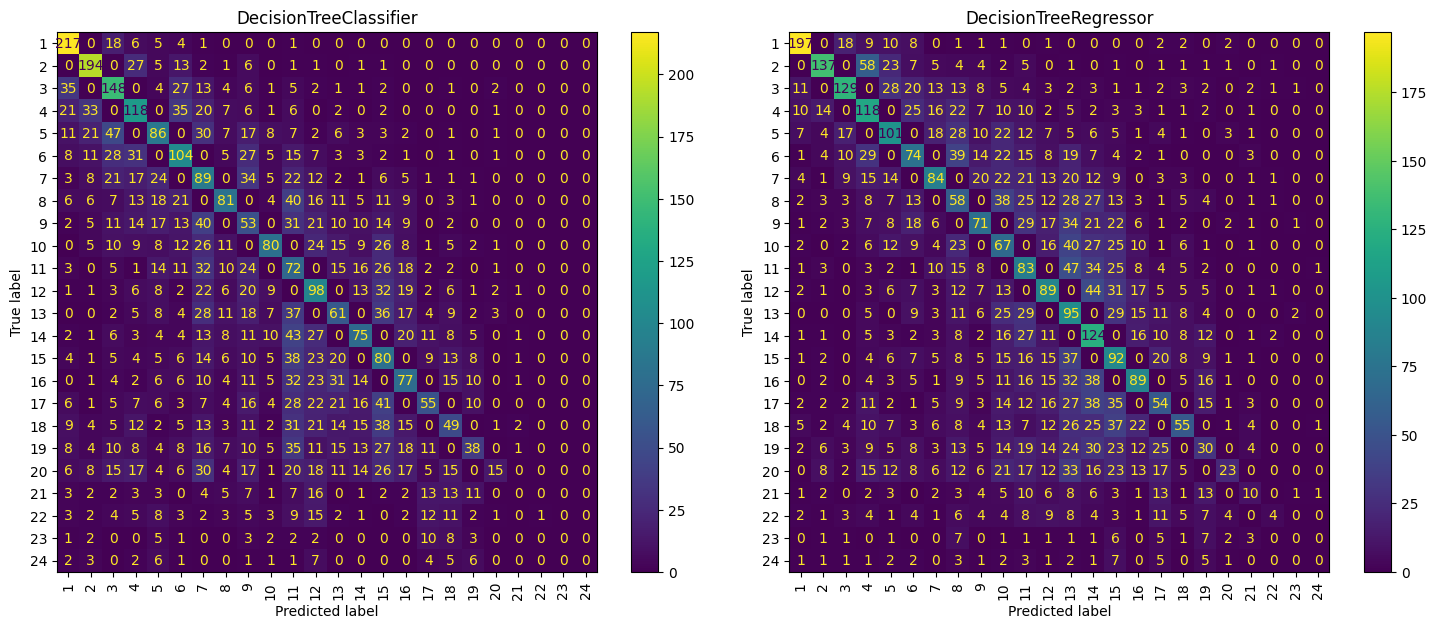

In [38]:
tree = (
    DecisionTreeClassifier(max_depth=4, criterion="entropy"),
    DecisionTreeRegressor(max_depth=5, criterion="absolute_error"),
)
model_test(tree, X, y, tscv, scorers=scorers, interval=1)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=20,
                       n_jobs=-1):
CV with make_scorer(balanced_accuracy_1interval_score): 0.33191411492547856
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.741958586095983
              precision    recall  f1-score   support

           1       0.43      0.96      0.59       252
           2       0.64      0.80      0.71       252
           3       0.46      0.48      0.47       252
           4       0.38      0.41      0.40       252
           5       0.36      0.31      0.33       252
           6       0.31      0.38      0.34       252
           7       0.27      0.34      0.30       252
           8       0.39      0.29      0.33       252
           9       0.20      0.22      0.21       252
          10       0.29      0.27      0.28       252
          11       0.28      0.34      0.31       252
          12       0.20      0.35      0.25       252
          13    

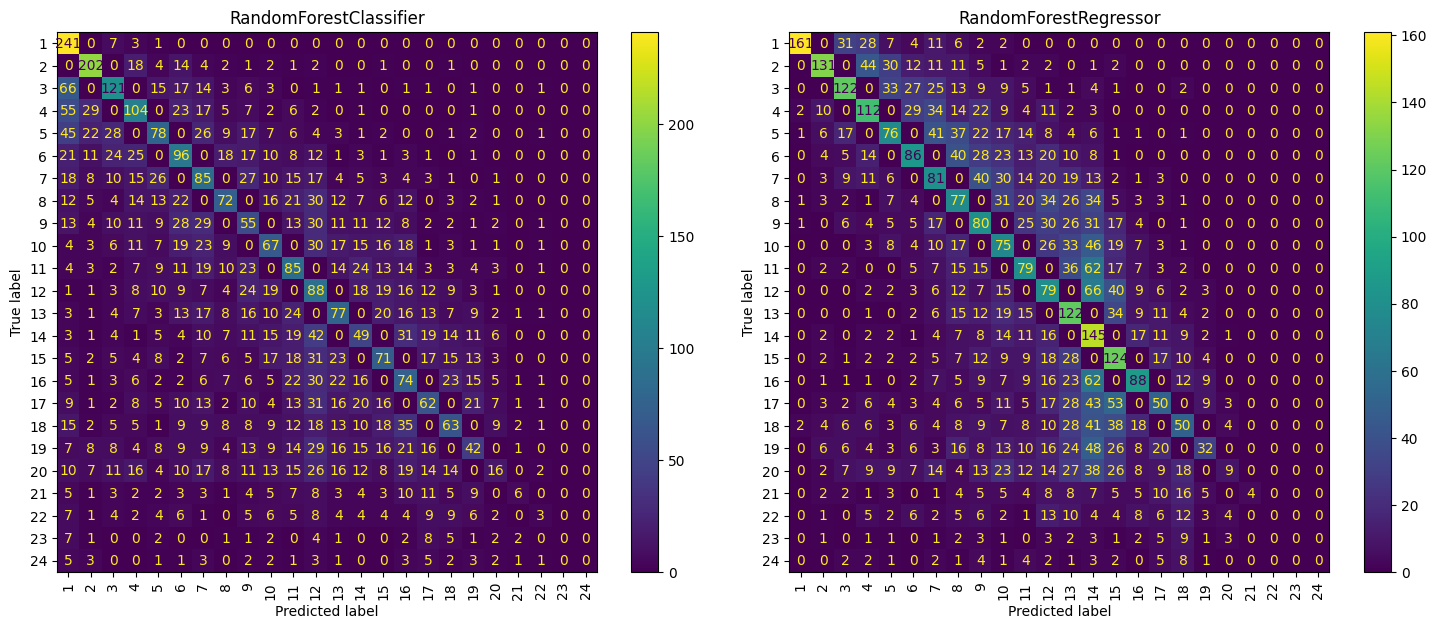

In [39]:
random_forest = (
    RandomForestClassifier(
        n_estimators=20, max_depth=4, criterion="entropy", n_jobs=-1
    ),
    RandomForestRegressor(
        n_estimators=20, max_depth=4, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv, scorers=scorers, interval=1)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_1interval_score): 0.356107844176026
CV with make_scorer(mean_absolute_1interval_error, greater_is_better=False): -3.4514752118425918
              precision    recall  f1-score   support

           1       0.62      0.92      0.74       252
           2       0.62      0.76      0.68       252
           3       0.54      0.53      0.53       252
           4       0.40      0.47      0.43       252
           5       0.38      0.48      0.42       252
           6       0.33      0.48      0.39       252
           7       0.25      0.39      0.31       252
           8       0.41      0.31      0.36       252
           9       0.23      0.21      0.22       252
          10       0.39      0.29      0.34       252
          11       0.19      0.30      0.23       252
          12       0.30      0.38      0.34       252
          13       0.24      0.29      0.26       252
     

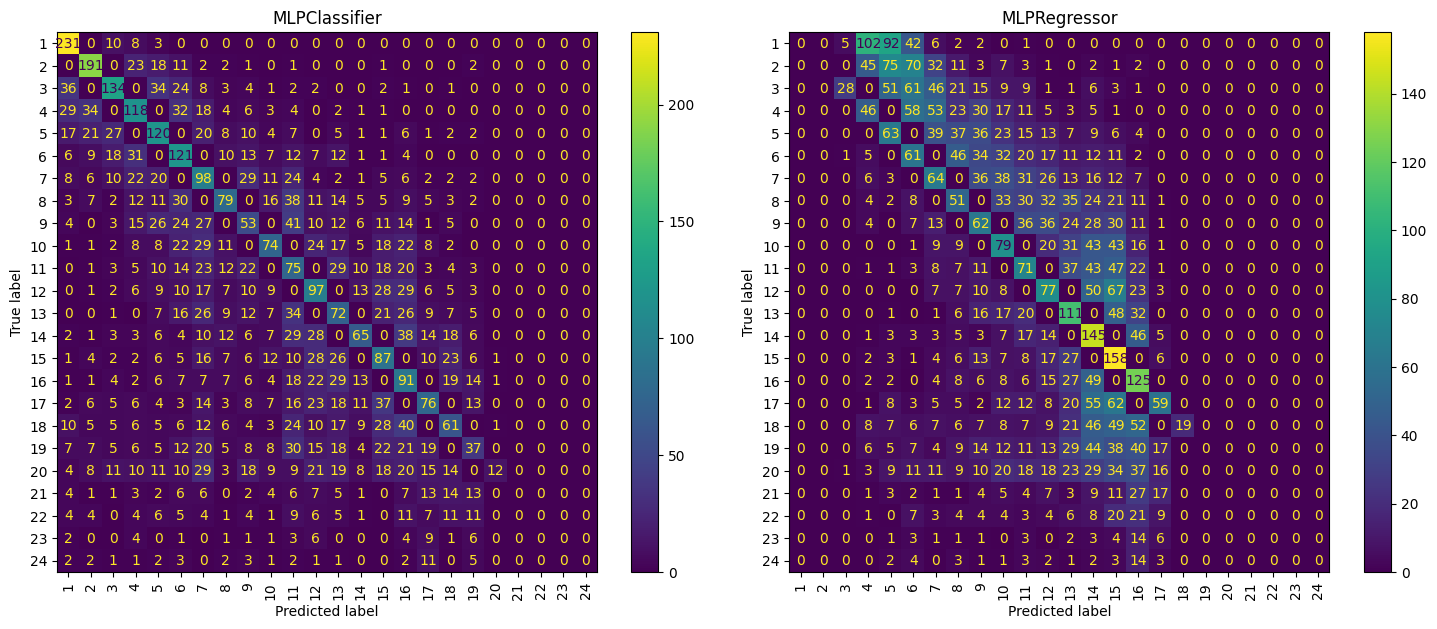

In [40]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv, scorers=scorers, interval=1)

The third objective attribute to be addressed will be the final position in fixed intervals of size 3.


In [41]:
max_pos = df["positionFinal"].max() + 1
intervals = np.array([f"{x}-{x+2}" for x in np.arange(1, max_pos, 3)])
y = df["positionFinal"].map(lambda x: np.ceil(x / 3 - 1).astype(np.int32))

KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=81):
CV with make_scorer(balanced_accuracy_score): 0.277837271494811
CV with neg_mean_absolute_error: -1.34096620832382
              precision    recall  f1-score   support

         1-3       0.61      0.60      0.60       756
         4-6       0.30      0.30      0.30       756
         7-9       0.21      0.28      0.24       756
       10-12       0.20      0.32      0.24       756
       13-15       0.23      0.24      0.24       756
       16-18       0.29      0.27      0.28       756
       19-21       0.29      0.05      0.09       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.29      5301
   macro avg       0.27      0.26      0.25      5301
weighted avg       0.29      0.29      0.28      5301

KNeighborsRegressor(metric='cosine', n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.22452282903903714
CV with neg_mean_absolute_error: -1.39289415934310

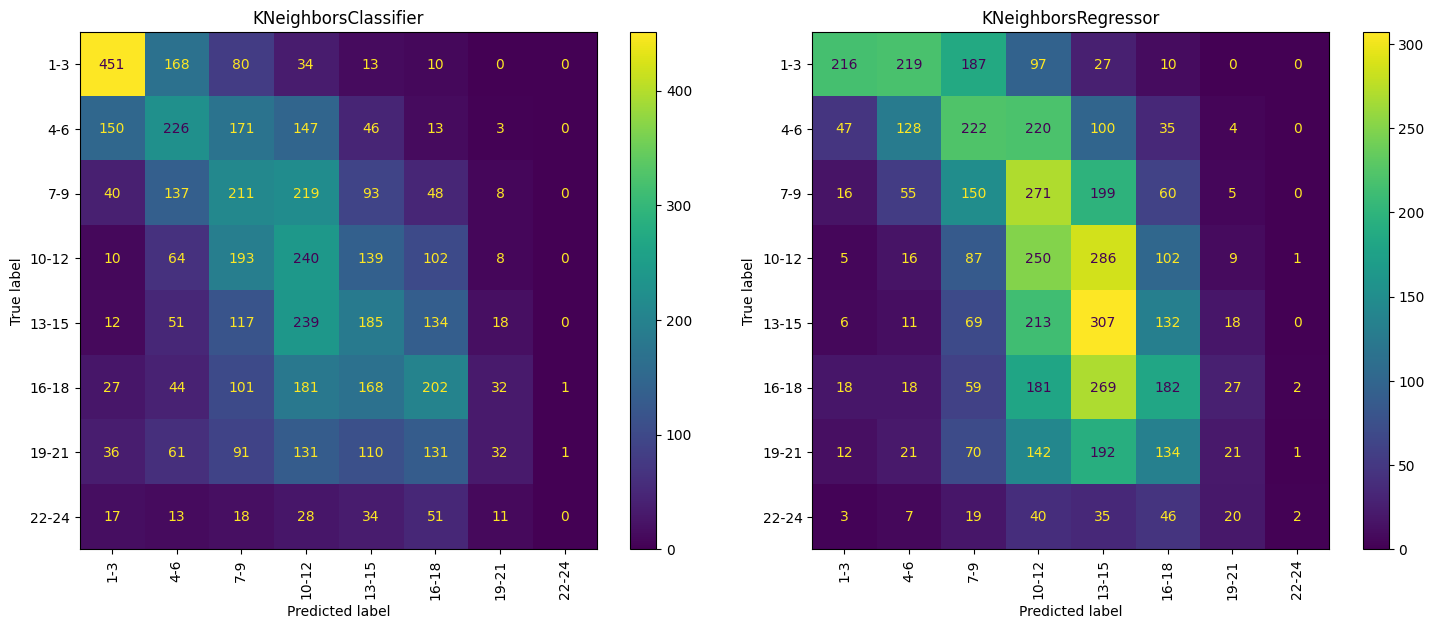

In [42]:
knn = (
    KNeighborsClassifier(n_neighbors=81, metric="manhattan", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=5, metric="cosine", n_jobs=-1),
)
model_test(knn, X, y, tscv, labels=intervals)

DecisionTreeClassifier(criterion='entropy', max_depth=4):
CV with make_scorer(balanced_accuracy_score): 0.3237355956276684
CV with neg_mean_absolute_error: -1.2326492428211229
              precision    recall  f1-score   support

         1-3       0.61      0.72      0.66       756
         4-6       0.36      0.42      0.39       756
         7-9       0.27      0.38      0.31       756
       10-12       0.22      0.29      0.25       756
       13-15       0.27      0.32      0.29       756
       16-18       0.36      0.21      0.26       756
       19-21       0.38      0.08      0.13       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.34      5301
   macro avg       0.31      0.30      0.29      5301
weighted avg       0.34      0.34      0.32      5301

DecisionTreeRegressor(criterion='absolute_error', max_depth=4):
CV with make_scorer(balanced_accuracy_score): 0.3176941617187552
CV with neg_mean_absolute_error: -1.17470725

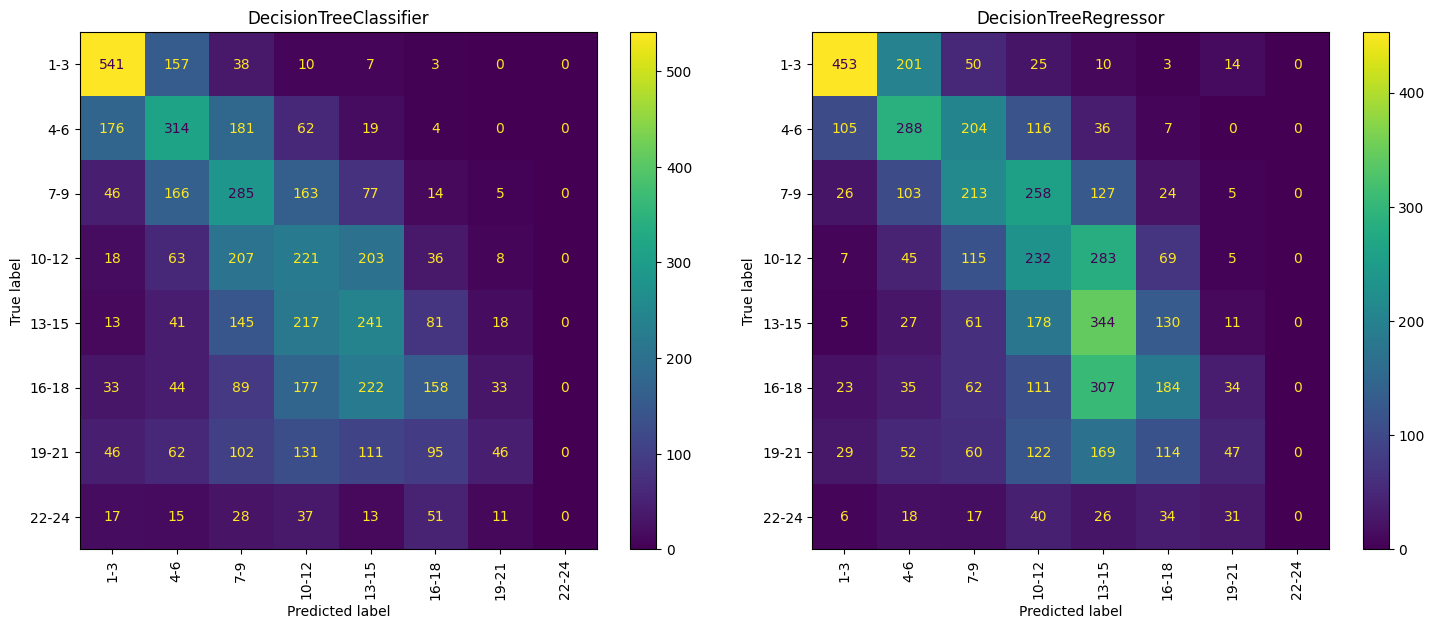

In [43]:
tree = (
    DecisionTreeClassifier(max_depth=4, criterion="entropy"),
    DecisionTreeRegressor(max_depth=4, criterion="absolute_error"),
)
model_test(tree, X, y, tscv, labels=intervals)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=10,
                       n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.31782939806927674
CV with neg_mean_absolute_error: -1.2887452381807567
              precision    recall  f1-score   support

         1-3       0.56      0.78      0.65       756
         4-6       0.35      0.40      0.37       756
         7-9       0.27      0.27      0.27       756
       10-12       0.23      0.32      0.27       756
       13-15       0.26      0.20      0.22       756
       16-18       0.29      0.31      0.30       756
       19-21       0.24      0.07      0.10       593
       22-24       0.33      0.02      0.04       172

    accuracy                           0.33      5301
   macro avg       0.32      0.30      0.28      5301
weighted avg       0.32      0.33      0.31      5301

RandomForestRegressor(criterion='absolute_error', max_depth=4, n_estimators=10,
                      n_jobs=-1):
CV with

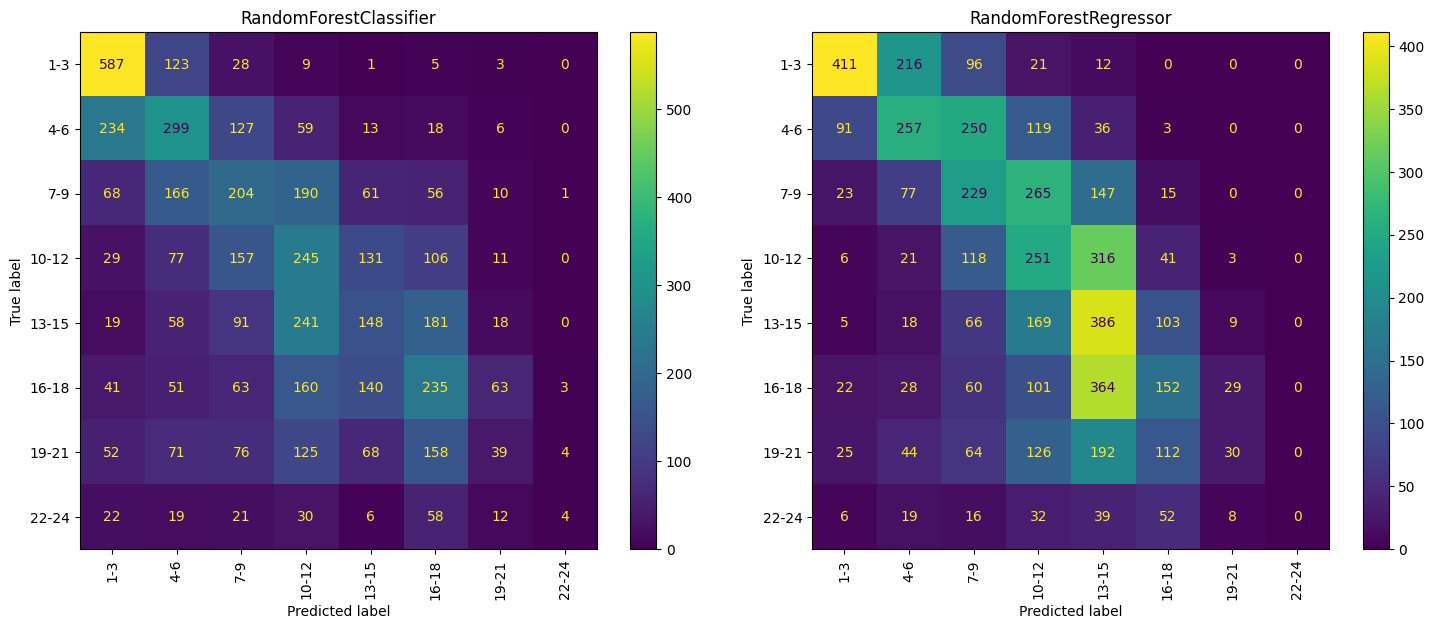

In [44]:
random_forest = (
    RandomForestClassifier(
        n_estimators=10, max_depth=4, criterion="entropy", n_jobs=-1
    ),
    RandomForestRegressor(
        n_estimators=10, max_depth=4, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv, labels=intervals)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_score): 0.33415310898588235
CV with neg_mean_absolute_error: -1.1978966939690756
              precision    recall  f1-score   support

         1-3       0.62      0.73      0.67       756
         4-6       0.35      0.45      0.39       756
         7-9       0.27      0.33      0.30       756
       10-12       0.24      0.30      0.27       756
       13-15       0.27      0.24      0.25       756
       16-18       0.32      0.34      0.33       756
       19-21       0.28      0.05      0.09       593
       22-24       0.00      0.00      0.00       172

    accuracy                           0.35      5301
   macro avg       0.29      0.31      0.29      5301
weighted avg       0.33      0.35      0.33      5301

MLPRegressor(activation='logistic', hidden_layer_sizes=(60, 30)):
CV with make_scorer(balanced_accuracy_score): 0.22853625415909404
CV with neg_mean_absolute_error

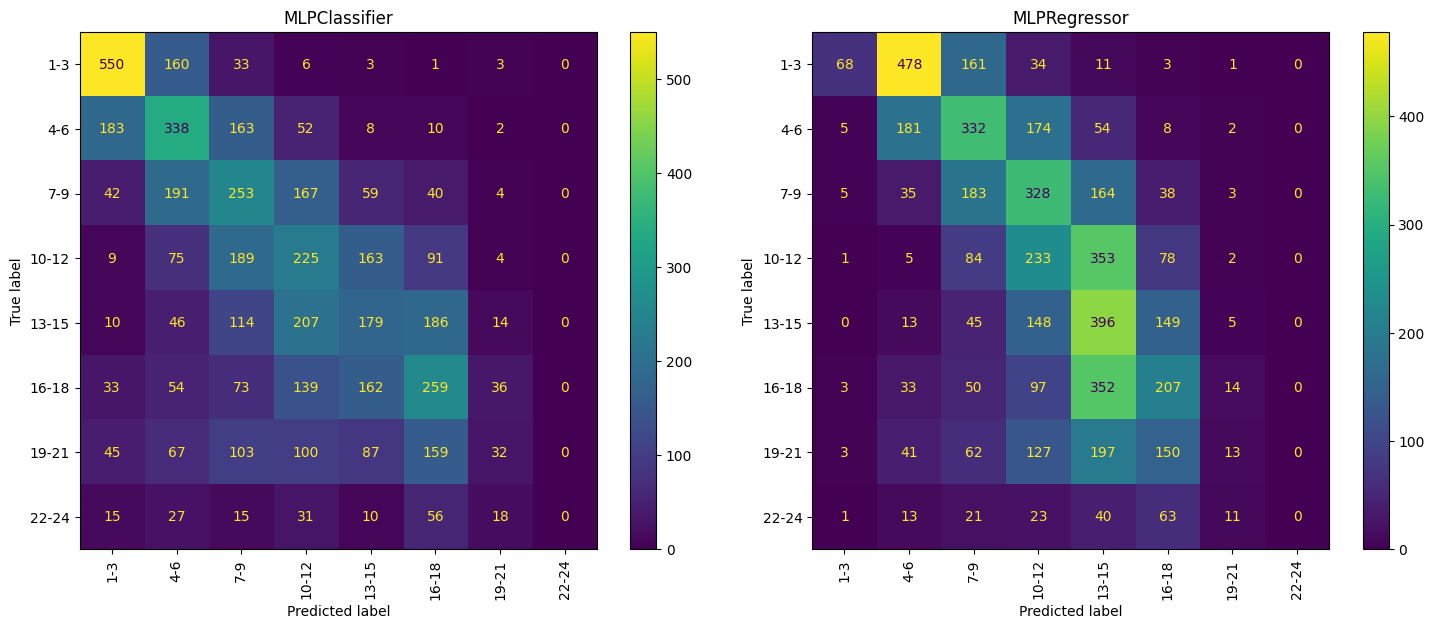

In [45]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv, labels=intervals)

The fourth objective attribute to be addressed will be if the driver is winner or not.


In [46]:
labels = np.array(["not_winner", "winner"])
winners = df[df["positionFinal"] == 1][["raceYear", "raceRound", "driverRef"]]
y = df.merge(winners, how="left", on=["raceYear", "raceRound"], suffixes=("", "Winner"))
y = y.apply(lambda x: x["driverRef"] == x["driverRefWinner"], axis=1)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=1):
CV with make_scorer(balanced_accuracy_score): 0.6954211321012392
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_winner       0.97      0.97      0.97      5049
      winner       0.42      0.41      0.41       252

    accuracy                           0.94      5301
   macro avg       0.69      0.69      0.69      5301
weighted avg       0.94      0.94      0.94      5301

KNeighborsRegressor(metric='euclidean', n_jobs=-1, n_neighbors=1):
CV with make_scorer(balanced_accuracy_score): 0.6954211321012392
CV with neg_mean_absolute_error: -0.0544865924221641
              precision    recall  f1-score   support

  not_winner       0.97      0.97      0.97      5049
      winner       0.42      0.41      0.41       252

    accuracy                           0.94      5301
   macro avg       0.69      0.69      0.69      5301
weighted avg       0.94      0.94      0.94   

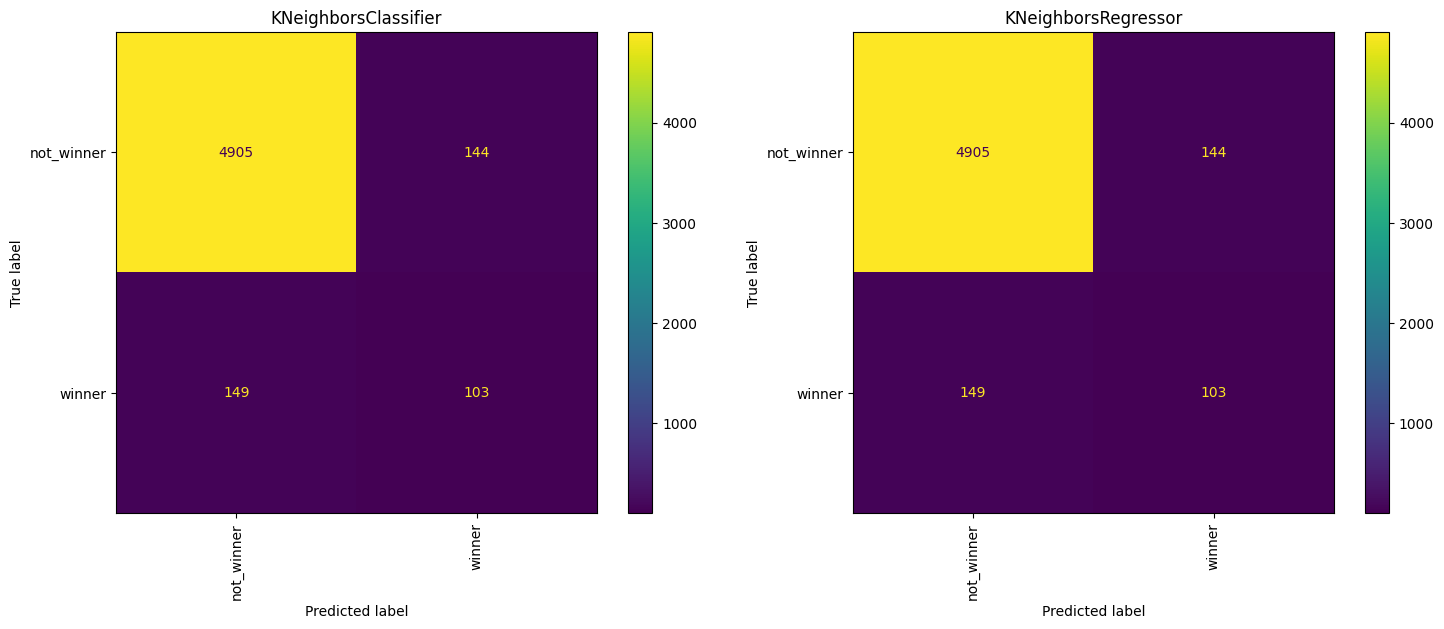

In [47]:
knn = (
    KNeighborsClassifier(n_neighbors=1, metric="euclidean", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=1, metric="euclidean", n_jobs=-1),
)
model_test(knn, X, y, tscv, labels=labels)

DecisionTreeClassifier(max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.8117272535805304
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_winner       0.98      0.97      0.98      5049
      winner       0.52      0.64      0.58       252

    accuracy                           0.95      5301
   macro avg       0.75      0.81      0.78      5301
weighted avg       0.96      0.95      0.96      5301

DecisionTreeRegressor(criterion='absolute_error', max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.6407473166273314
CV with neg_mean_absolute_error: -0.05399173951164983
              precision    recall  f1-score   support

  not_winner       0.96      0.98      0.97      5049
      winner       0.42      0.27      0.33       252

    accuracy                           0.95      5301
   macro avg       0.69      0.63      0.65      5301
weighted avg       0.94      0.95      0.94      5301



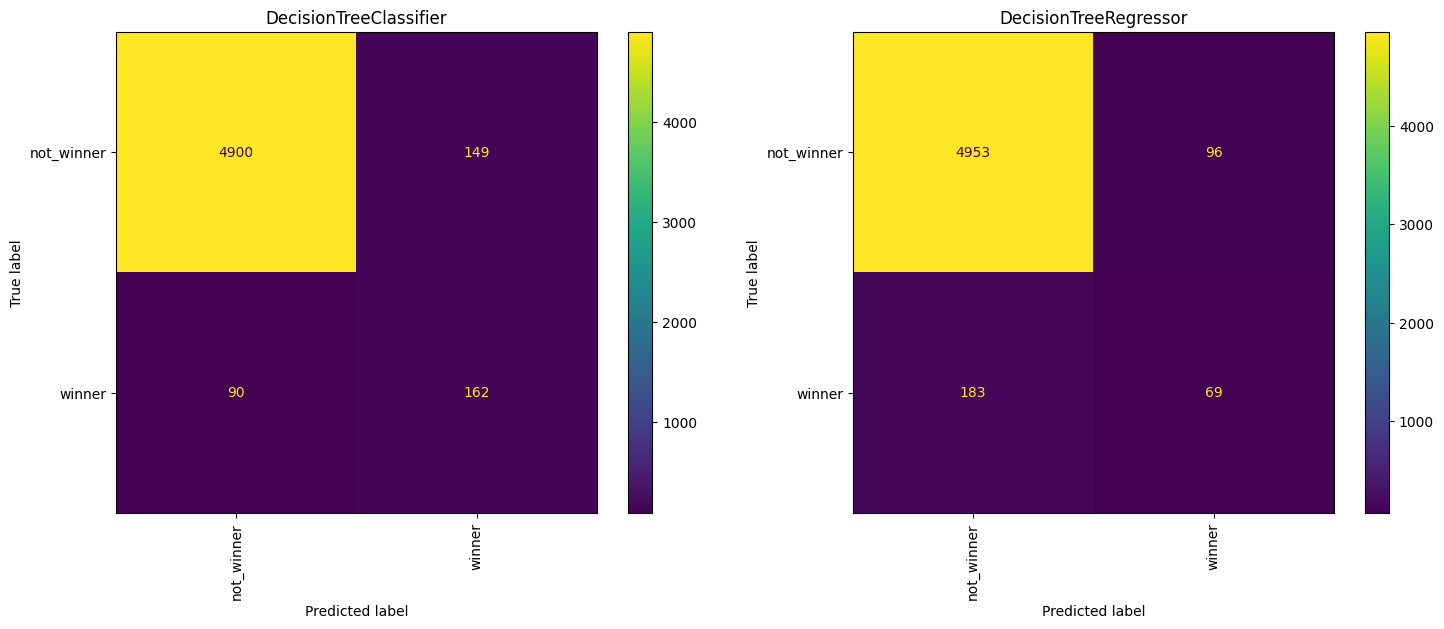

In [48]:
tree = (
    DecisionTreeClassifier(max_depth=2, criterion="gini"),
    DecisionTreeRegressor(max_depth=2, criterion="absolute_error"),
)
model_test(tree, X, y, tscv, labels=labels)

RandomForestClassifier(max_depth=8, n_estimators=5, n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.6855527678822662
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_winner       0.97      0.98      0.98      5049
      winner       0.54      0.38      0.44       252

    accuracy                           0.96      5301
   macro avg       0.75      0.68      0.71      5301
weighted avg       0.95      0.96      0.95      5301

RandomForestRegressor(criterion='absolute_error', max_depth=8, n_estimators=5,
                      n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.6784224693480548
CV with neg_mean_absolute_error: -0.05944622918667437
              precision    recall  f1-score   support

  not_winner       0.97      0.98      0.97      5049
      winner       0.45      0.35      0.40       252

    accuracy                           0.95      5301
   macro avg       0.71      0.67      0.68      5301
wei

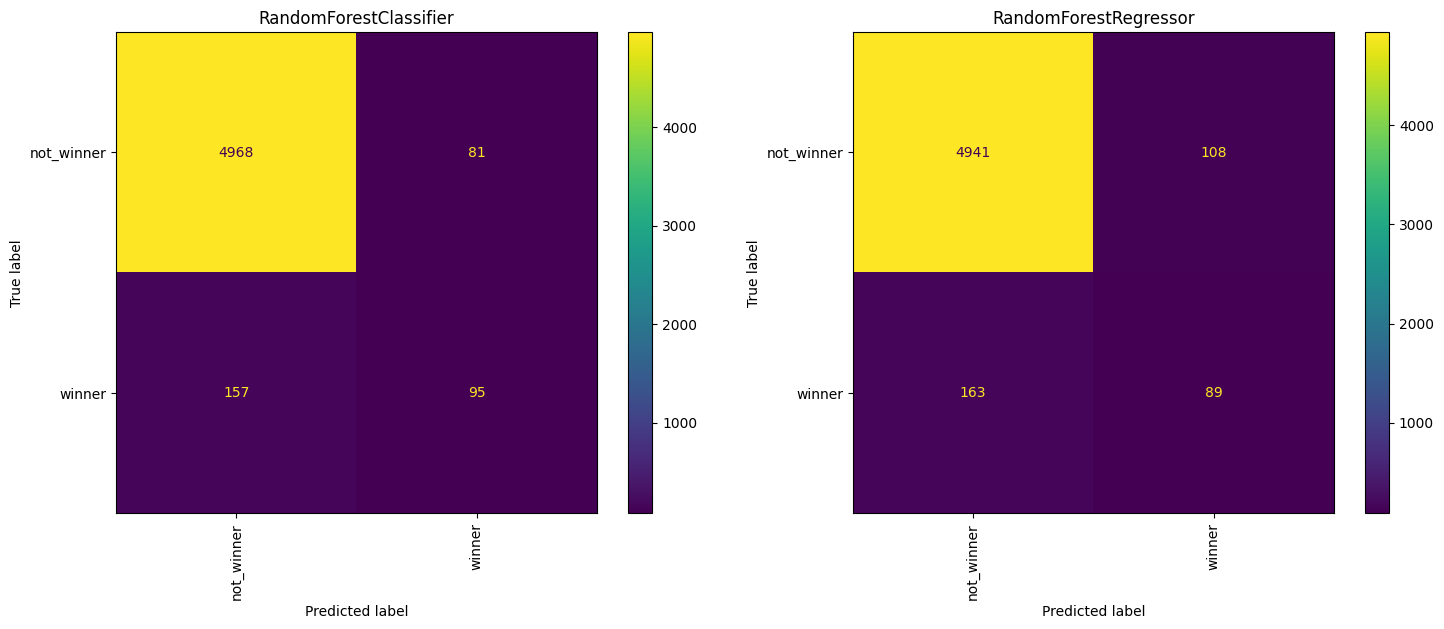

In [49]:
random_forest = (
    RandomForestClassifier(n_estimators=5, max_depth=8, criterion="gini", n_jobs=-1),
    RandomForestRegressor(
        n_estimators=5, max_depth=8, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv, labels=labels)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_score): 0.7537159712384918
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_winner       0.97      0.99      0.98      5049
      winner       0.62      0.49      0.55       252

    accuracy                           0.96      5301
   macro avg       0.80      0.74      0.76      5301
weighted avg       0.96      0.96      0.96      5301

MLPRegressor(activation='logistic', hidden_layer_sizes=(60, 30)):
CV with make_scorer(balanced_accuracy_score): 0.607423466601779
CV with neg_mean_absolute_error: -0.0782067963060339
              precision    recall  f1-score   support

  not_winner       0.96      0.99      0.98      5049
      winner       0.57      0.17      0.26       252

    accuracy                           0.95      5301
   macro avg       0.76      0.58      0.62      5301
weighted avg       0.94      0.95      0.94      

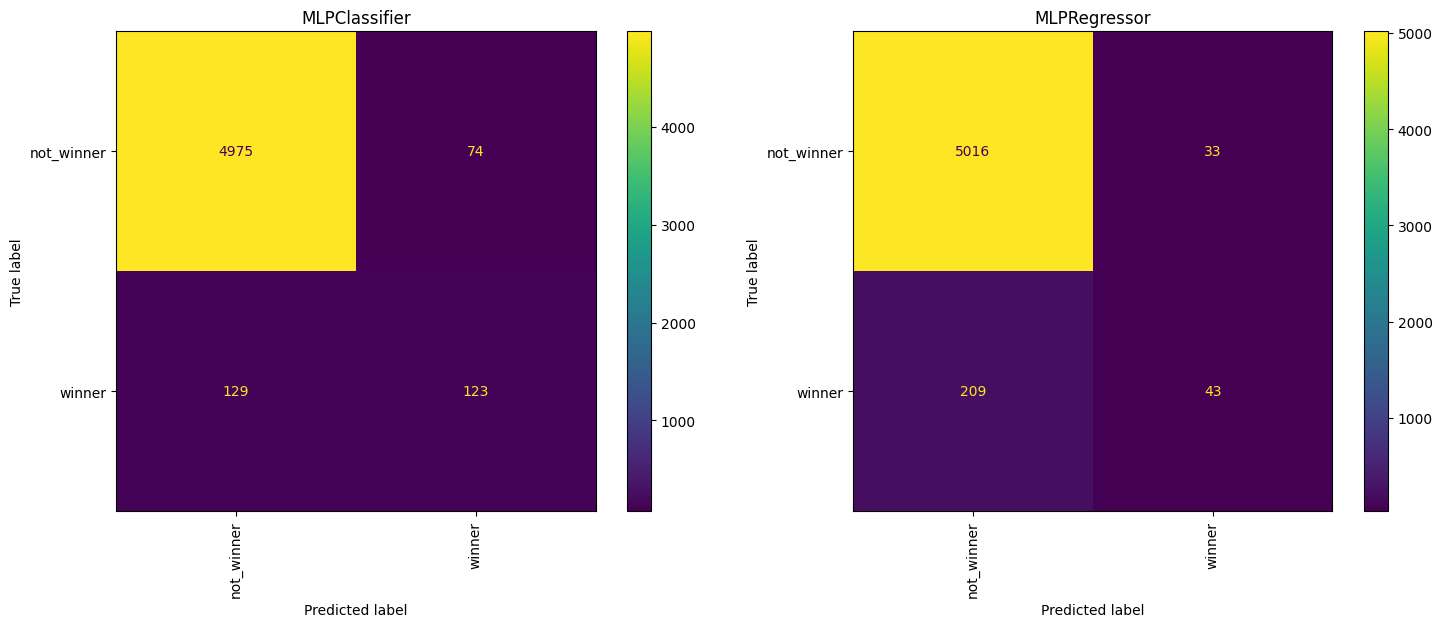

In [50]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv, labels=labels)

The fifth objective attribute to be addressed will be if the driver is podium or not.


In [51]:
labels = np.array(["not_podium", "podium"])
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

KNeighborsClassifier(metric='cosine', n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.718857150973029
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.92      0.95      0.93      4545
      podium       0.61      0.49      0.55       756

    accuracy                           0.88      5301
   macro avg       0.77      0.72      0.74      5301
weighted avg       0.87      0.88      0.88      5301

KNeighborsRegressor(metric='cosine', n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.718857150973029
CV with neg_mean_absolute_error: -0.14411025781726114
              precision    recall  f1-score   support

  not_podium       0.92      0.95      0.93      4545
      podium       0.61      0.49      0.55       756

    accuracy                           0.88      5301
   macro avg       0.77      0.72      0.74      5301
weighted avg       0.87      0.88      0.88      5301



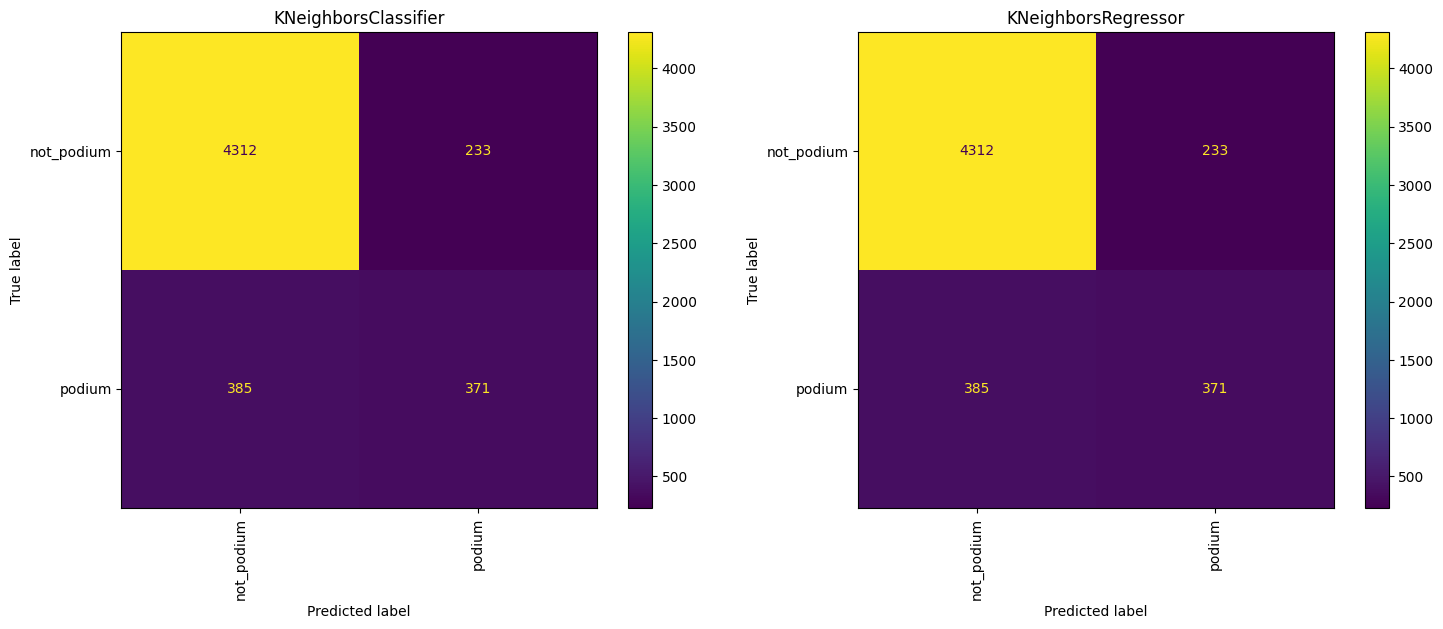

In [52]:
knn = (
    KNeighborsClassifier(n_neighbors=5, metric="cosine", n_jobs=-1),
    KNeighborsRegressor(n_neighbors=5, metric="cosine", n_jobs=-1),
)
model_test(knn, X, y, tscv, labels=labels)

DecisionTreeClassifier(max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.776910425510872
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.95      4545
      podium       0.70      0.59      0.64       756

    accuracy                           0.91      5301
   macro avg       0.82      0.78      0.79      5301
weighted avg       0.90      0.91      0.90      5301

DecisionTreeRegressor(criterion='absolute_error', max_depth=2):
CV with make_scorer(balanced_accuracy_score): 0.7764118505491131
CV with neg_mean_absolute_error: -0.09594790831072458
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.95      4545
      podium       0.70      0.58      0.64       756

    accuracy                           0.91      5301
   macro avg       0.82      0.77      0.79      5301
weighted avg       0.90      0.91      0.90      5301



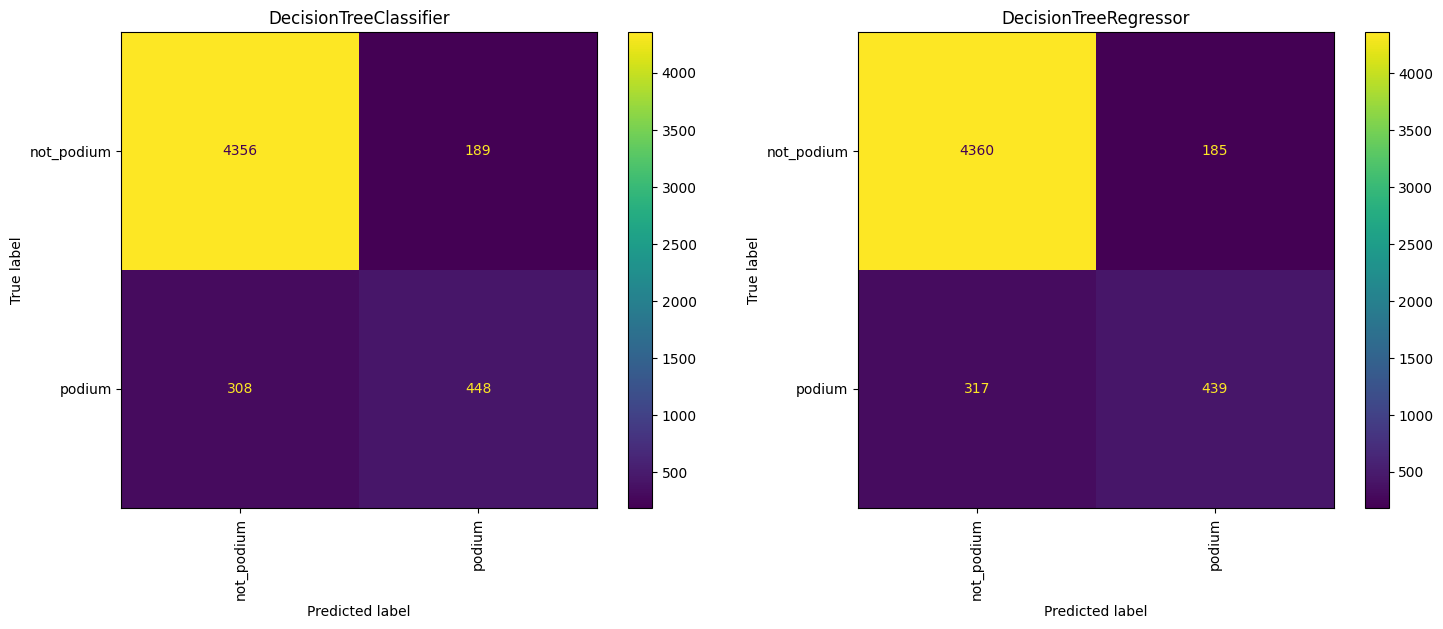

In [53]:
tree = (
    DecisionTreeClassifier(max_depth=2, criterion="gini"),
    DecisionTreeRegressor(max_depth=2, criterion="absolute_error"),
)
model_test(tree, X, y, tscv, labels=labels)

RandomForestClassifier(max_depth=5, n_estimators=7, n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7431196900311365
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.93      0.96      0.94      4545
      podium       0.70      0.54      0.61       756

    accuracy                           0.90      5301
   macro avg       0.81      0.75      0.78      5301
weighted avg       0.89      0.90      0.90      5301

RandomForestRegressor(criterion='absolute_error', max_depth=5, n_estimators=7,
                      n_jobs=-1):
CV with make_scorer(balanced_accuracy_score): 0.7754708940293249
CV with neg_mean_absolute_error: -0.10450351574711028
              precision    recall  f1-score   support

  not_podium       0.93      0.95      0.94      4545
      podium       0.67      0.57      0.61       756

    accuracy                           0.90      5301
   macro avg       0.80      0.76      0.78      5301
wei

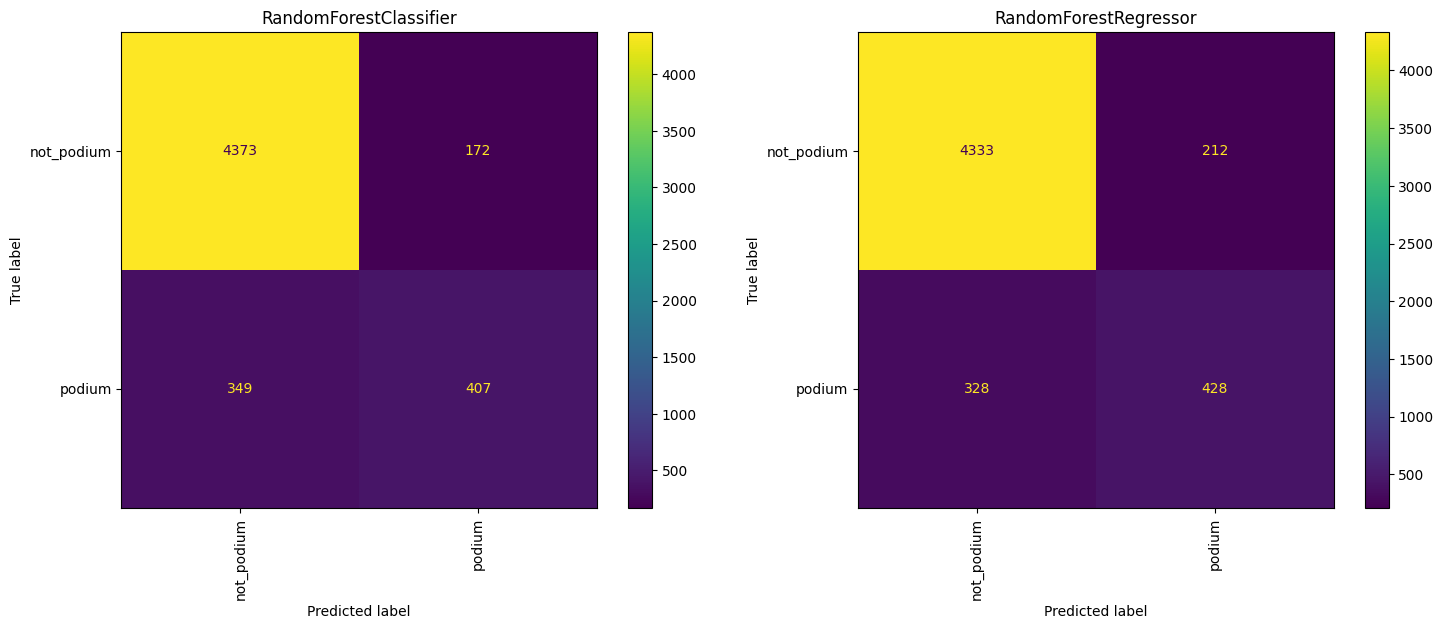

In [54]:
random_forest = (
    RandomForestClassifier(n_estimators=7, max_depth=5, criterion="gini", n_jobs=-1),
    RandomForestRegressor(
        n_estimators=7, max_depth=5, criterion="absolute_error", n_jobs=-1
    ),
)
model_test(random_forest, X, y, tscv, labels=labels)

MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 25)):
CV with make_scorer(balanced_accuracy_score): 0.7920220329773707
CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.94      0.95      0.95      4545
      podium       0.70      0.63      0.66       756

    accuracy                           0.91      5301
   macro avg       0.82      0.79      0.80      5301
weighted avg       0.90      0.91      0.91      5301

MLPRegressor(activation='logistic', hidden_layer_sizes=(60, 30)):
CV with make_scorer(balanced_accuracy_score): 0.7133153604171033
CV with neg_mean_absolute_error: -0.17337409901379747
              precision    recall  f1-score   support

  not_podium       0.91      0.97      0.94      4545
      podium       0.72      0.45      0.55       756

    accuracy                           0.90      5301
   macro avg       0.81      0.71      0.75      5301
weighted avg       0.89      0.90      0.89    

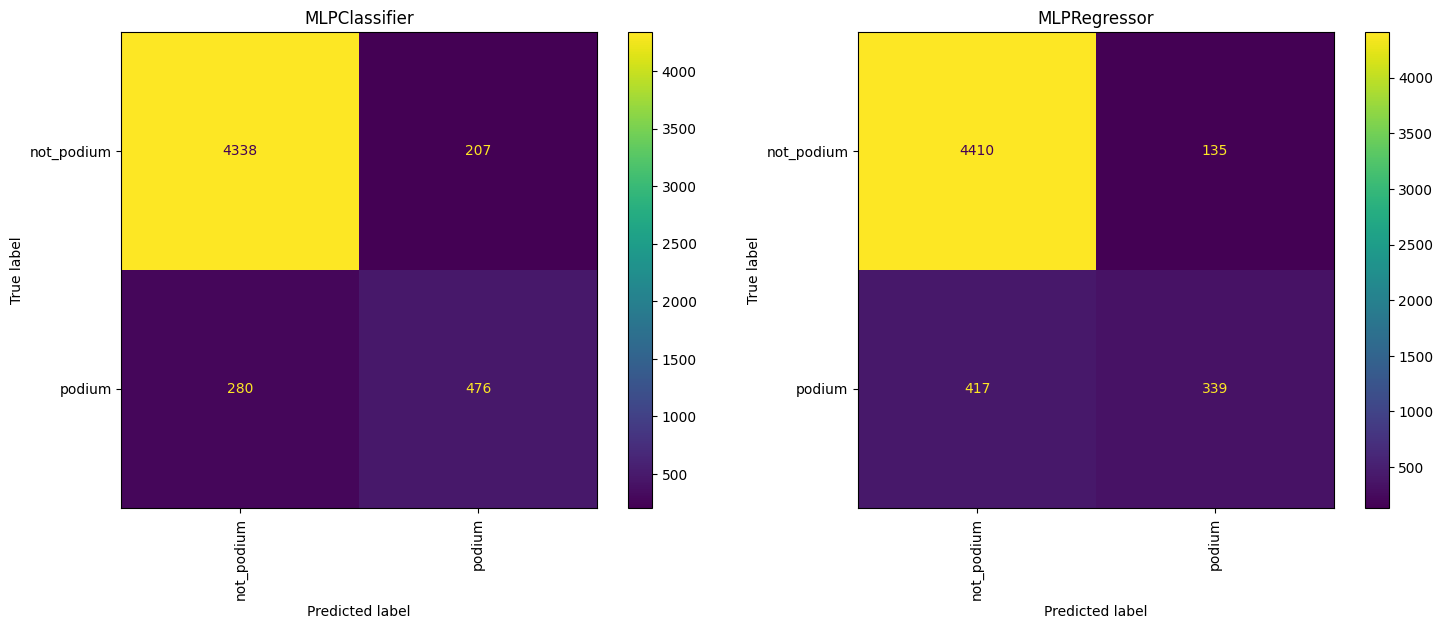

In [55]:
nn = (
    MLPClassifier(hidden_layer_sizes=(50, 25), activation="logistic"),
    MLPRegressor(hidden_layer_sizes=(60, 30), activation="logistic"),
)
model_test(nn, X, y, tscv, labels=labels)

With the results obtained, we will proceed with the following models

- Final position of the driver in a +-1 interval
- The driver is podium or not

This is because accurately predicting the position of each pilot is really unfeasible, and, between variable and fixed intervals, the second option has been selected simply out of desire, since the two are similar in results.

On the other hand, it has been chosen to determine the podium instead of the winner since, in these times, we all know that the winner this season will be Verstappen with a 99% probability.

In addition, classification models over regression models will be chosen since the results are slightly better in the first mentioned.


## Simple Hyperparameter Tuning


For the improvement of the selected models, we will first do a simple hyperparameter tuning. For this we can use mainly two methods

- For a more exhaustive search, GridSearch
- For a more stochastic search, RandomizedSearch

In our case we will use the first option mentioned above for more consistent results. Likewise, the hyperparameters will be re-selected in later sections in a more rigorous way.

First we will do the tuning of the model that predicts the final position of each driver at a +-1 interval.


In [56]:
y = df["positionFinal"]

In [57]:
grid = dict(
    n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 21, 31, 51, 101],
    weights=["uniform", "distance", None],
    metric=["euclidean", "manhattan", "cosine"],
)
search = GridSearchCV(
    KNeighborsClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_1interval_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"KNeighborsClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

KNeighborsClassifier: 0.2863537094218912 with {'metric': 'manhattan', 'n_neighbors':
	101, 'weights': 'distance'}


In [58]:
grid = dict(
    criterion=["gini", "entropy", "log_loss"],
    splitter=["best", "random"],
    max_depth=[2, 3, 4, 5, 6, 10, 20],
)
search = GridSearchCV(
    DecisionTreeClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_1interval_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"DecisionTreeClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

DecisionTreeClassifier: 0.34112213333804237 with {'criterion': 'gini', 'max_depth': 5,
	'splitter': 'best'}


In [59]:
grid = dict(
    n_estimators=[10, 30, 50, 100, 200],
    criterion=["gini", "entropy", "log_loss"],
    max_depth=[2, 3, 4, 5, 6, 10, 20],
)
search = GridSearchCV(
    RandomForestClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_1interval_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"RandomForestClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

RandomForestClassifier: 0.3479073809187445 with {'criterion': 'gini', 'max_depth': 5,
	'n_estimators': 100}


In [60]:
grid = dict(
    hidden_layer_sizes=[(100,), (50, 25), (50, 20, 5)],
    activation=["relu", "logistic"],
)
search = GridSearchCV(
    MLPClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_1interval_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"MLPClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

MLPClassifier: 0.3586966547762002 with {'activation': 'logistic', 'hidden_layer_sizes':
	(50, 25)}


After viewing several runs, the hyperparameters for each algorithm are as follows

- KNeighborsClassifier: 0.2863537094218912 with {'metric': 'manhattan', 'n_neighbors': 101, 'weights': 'uniform'}
- DecisionTreeClassifier: 0.34112213333804237 with {'criterion': 'gini', 'max_depth': 4, 'splitter': 'best'}
- RandomForestClassifier: 0.3479073809187445 with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}
- MLPClassifier: 0.3586966547762002 with {'activation': 'logistic', 'hidden_layer_sizes': (50, 25)}

We continue with the tuning of the model that predicts the podium


In [61]:
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

In [62]:
grid = dict(
    n_neighbors=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 21, 31, 51, 101],
    weights=["uniform", "distance", None],
    metric=["euclidean", "manhattan", "cosine"],
)
search = GridSearchCV(
    KNeighborsClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"KNeighborsClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

KNeighborsClassifier: 0.7263922435898924 with {'metric': 'cosine', 'n_neighbors': 5,
	'weights': 'distance'}


In [63]:
grid = dict(
    criterion=["gini", "entropy", "log_loss"],
    splitter=["best", "random"],
    max_depth=[2, 3, 4, 5, 6, 10, 20],
)
search = GridSearchCV(
    DecisionTreeClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"DecisionTreeClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

DecisionTreeClassifier: 0.7892538259292045 with {'criterion': 'log_loss', 'max_depth':
	4, 'splitter': 'random'}


In [64]:
grid = dict(
    n_estimators=[10, 30, 50, 100, 200],
    criterion=["gini", "entropy", "log_loss"],
    max_depth=[2, 3, 4, 5, 6, 10, 20],
)
search = GridSearchCV(
    RandomForestClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"RandomForestClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

RandomForestClassifier: 0.7778548164328474 with {'criterion': 'gini', 'max_depth': 10,
	'n_estimators': 50}


In [65]:
grid = dict(
    hidden_layer_sizes=[(100,), (50, 25), (50, 20, 5)],
    activation=["relu", "logistic"],
)
search = GridSearchCV(
    MLPClassifier(),
    grid,
    scoring=make_scorer(balanced_accuracy_score),
    cv=tscv,
    n_jobs=-1,
).fit(X, y)
output = f"MLPClassifier: {search.best_score_} with {search.best_params_}"
print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

MLPClassifier: 0.799283305036914 with {'activation': 'logistic', 'hidden_layer_sizes':
	(50, 20, 5)}


After viewing several runs, the hyperparameters for each algorithm are as follows

- KNeighborsClassifier: 0.7263922435898924 with {'metric': 'cosine', 'n_neighbors': 5, 'weights': 'distance'}
- DecisionTreeClassifier: 0.7892538259292045 with {'criterion': 'gini', 'max_depth': 3, 'splitter': 'best'}
- RandomForestClassifier: 0.7778548164328474 with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
- MLPClassifier: 0.799283305036914 with {'activation': 'logistic', 'hidden_layer_sizes': (50, 20, 5)}


## Feature Selection


After hyperparameter tuning, we proceed to attribute selection. Three methods will be used for this

- To see the most important attributes, PermutationImportance
- For a more exhaustive search, SequentialForwardSelector
- For a more stochastic search, GeneticAlgorithms

The main method will be Sequential forward selection (SFS), in which features are sequentially added to an empty candidate set until the addition of more features does not lower the criterion.

PermutationImportance we will use it to corroborate the results, as well as to see which attributes contribute the most to the performance of the model. The performance obtained by this measure and the previous one may differ because, even if one measure is of little relevance by itself, combined with others it can improve the model significantly.

Finally, we will use genetic algorithms to check with a small stochastic search if there is a possibility that there are other combinations that improve performance. This is because SequentialForwardSelector adds measures starting from one measure, i.e., it does not check all combinations and there may be a better one. Regarding the genetic algorithm itself, the fitness function will correspond to the cross-validation of a binary individual, where a 1 in position i will represent that measure i is taken for the evaluation, and if it is 0 it is not.


In [66]:
def fitness_func(ga_instance, individual, individual_idx):
    res = []

    get_idx = lambda _: [i for i in range(len(individual)) if individual[i] == 1]
    attributes = X.iloc[:, get_idx]
    objective = y

    if not attributes.empty:
        res.extend(
            cross_val_score(
                estimator=estimator,
                X=attributes,
                y=objective,
                cv=tscv,
                scoring=scor,
                n_jobs=-1,
            )
        )

    avg_cross_val_score = sum(res) / len(res) if not attributes.empty else -10000
    return avg_cross_val_score

We will also define an auxiliary function to help us make the selection, as was done in previous sections for model validation.


In [67]:
def model_selection(model, scoring):
    # Global vars (to fitness_func)
    global estimator, scor
    estimator = model
    scor = scoring

    # Permutation Importance
    model.fit(X, y)
    r = permutation_importance(
        model,
        X,
        y,
        n_jobs=-1,
        scoring=scor,
        n_repeats=5,
    )

    # Sequential Forward Selector
    sfs = SFS(
        model,
        k_features=(1, len(X.columns)),
        scoring=scor,
        cv=tscv,
        n_jobs=-1,
    ).fit(X, y)

    # Genetic Algorithms
    individual_size = X.shape[1]
    ga_instance = GA(
        num_generations=sys.maxsize,
        num_parents_mating=2,
        fitness_func=fitness_func,
        sol_per_pop=25,
        num_genes=individual_size,
        gene_type=int,
        init_range_low=0,
        init_range_high=2,
        parent_selection_type="rws",
        keep_parents=1,
        crossover_type="single_point",
        crossover_probability=0.3,
        mutation_type="random",
        mutation_probability=0.05,
        stop_criteria=["saturate_5"],
    )
    ga_instance.run()

    # PI results
    mean = r.importances_mean
    std = r.importances_std
    pos = lambda i: mean[i] - 2 * std[i] > 0
    feature_idx = sorted([i for i in mean.argsort()[::-1] if pos(i)])
    feature_names = sorted([X.columns[i] for i in mean.argsort()[::-1] if pos(i)])
    scores = cross_val_score(
        model, X[feature_names], y, cv=tscv, scoring=scor, n_jobs=-1
    )
    output = "PI: %.3f with %s == %s" % (
        scores.sum() / len(scores),
        tuple(feature_idx),
        tuple(feature_names),
    )
    print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

    # SFS results
    output = "SFS: %.3f with %s == %s" % (
        sfs.k_score_,
        sfs.k_feature_idx_,
        sfs.k_feature_names_,
    )
    print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

    # GA results
    solution, solution_fitness, _ = ga_instance.best_solution()
    feature_idx = np.where(solution == 1)[0]
    feature_names = X.columns[feature_idx]
    output = "GA: %.3f with %s == %s" % (
        solution_fitness,
        tuple(feature_idx),
        tuple(feature_names),
    )
    print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))

    # Plot results
    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    dfp = pd.DataFrame(data=r.importances.T, columns=X.columns)
    meds = dfp.mean()
    meds.sort_values(ascending=True, inplace=True)
    dfp = dfp[meds.index]
    dfp.boxplot(vert=False, ax=ax1)
    ax1.title.set_text("Permutation Importance")
    ax1.set_xlabel("Importance")
    ax1.set_ylabel("Features")

    metric_dict = sfs.get_metric_dict()
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]["avg_score"] for k in k_feat]
    upper = [metric_dict[k]["avg_score"] + metric_dict[k]["std_dev"] for k in k_feat]
    lower = [metric_dict[k]["avg_score"] - metric_dict[k]["std_dev"] for k in k_feat]
    ax2.plot(k_feat, avg, color="blue", marker="o")
    ax2.fill_between(k_feat, upper, lower, alpha=0.2, color="steelblue", lw=1)
    ax2.set_xticks(range(1, len(X.columns) + 1))
    ax2.title.set_text("Sequential Forward Selection (w. StdDev)")
    ax2.set_xlabel("Number of Features")
    ax2.set_ylabel("Performance")
    ax2.grid()

    plt.tight_layout()
    plt.show()

First we will do the tuning of the model that predicts the final position of each driver at a +-1 interval.


In [68]:
y = df["positionFinal"]

PI: 0.336 with (0, 1, 17, 18) == ('carNumber', 'constructorWins', 'driverWins',
	'positionGrid')
SFS: 0.347 with (1, 5, 17) == ('positionGrid', 'constructorRef', 'driverWins')
GA: 0.316 with (1, 3, 5, 7, 14, 17, 18, 20) == ('positionGrid', 'driverNumber',
	'constructorRef', 'raceYear', 'circuitLat', 'driverWins', 'constructorWins', 'q2')


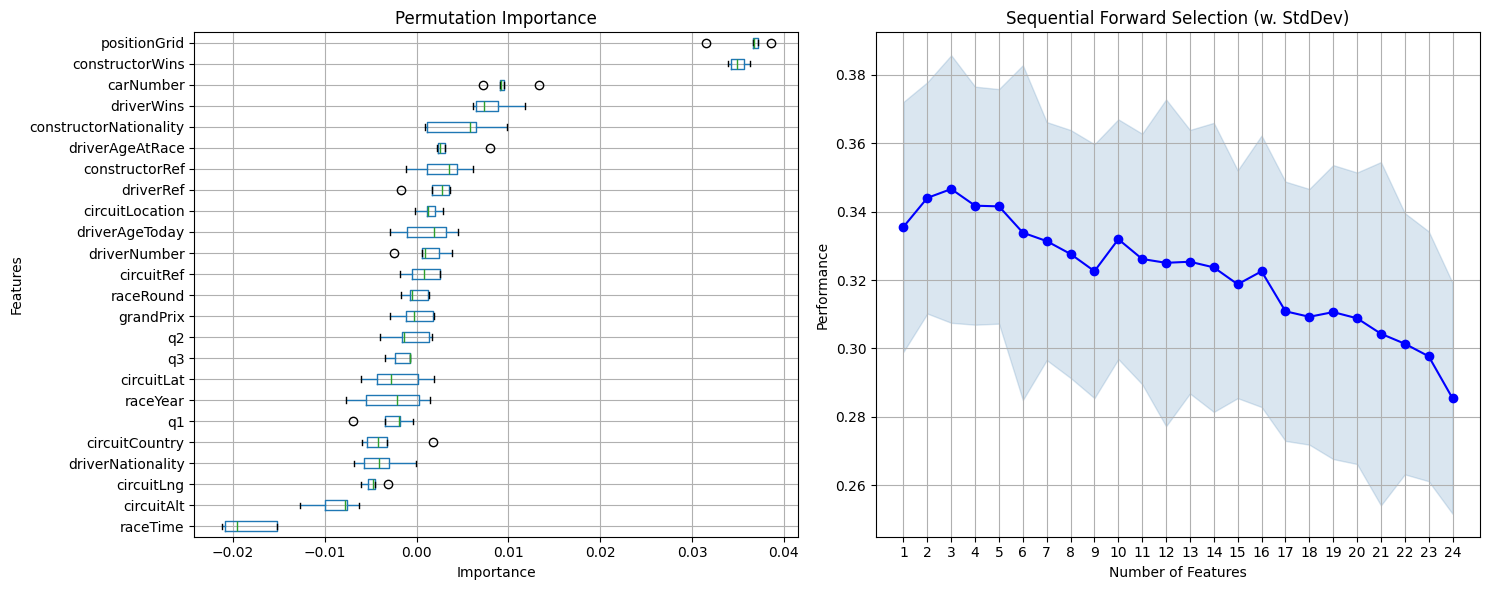

In [69]:
knn = KNeighborsClassifier(n_neighbors=101, metric="manhattan", weights="uniform")
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(knn, scoring)

PI: 0.347 with (1, 17, 18) == ('constructorWins', 'driverWins', 'positionGrid')
SFS: 0.355 with (1, 4, 6, 7, 8, 9, 10, 12, 13, 14, 17, 19, 20, 21) == ('positionGrid',
	'driverNationality', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix',
	'raceTime', 'circuitLocation', 'circuitCountry', 'circuitLat', 'driverWins', 'q1',
	'q2', 'q3')
GA: 0.347 with (0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20) == ('carNumber',
	'positionGrid', 'driverNumber', 'driverNationality', 'constructorNationality',
	'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitRef', 'circuitLat',
	'circuitLng', 'driverWins', 'constructorWins', 'q2')


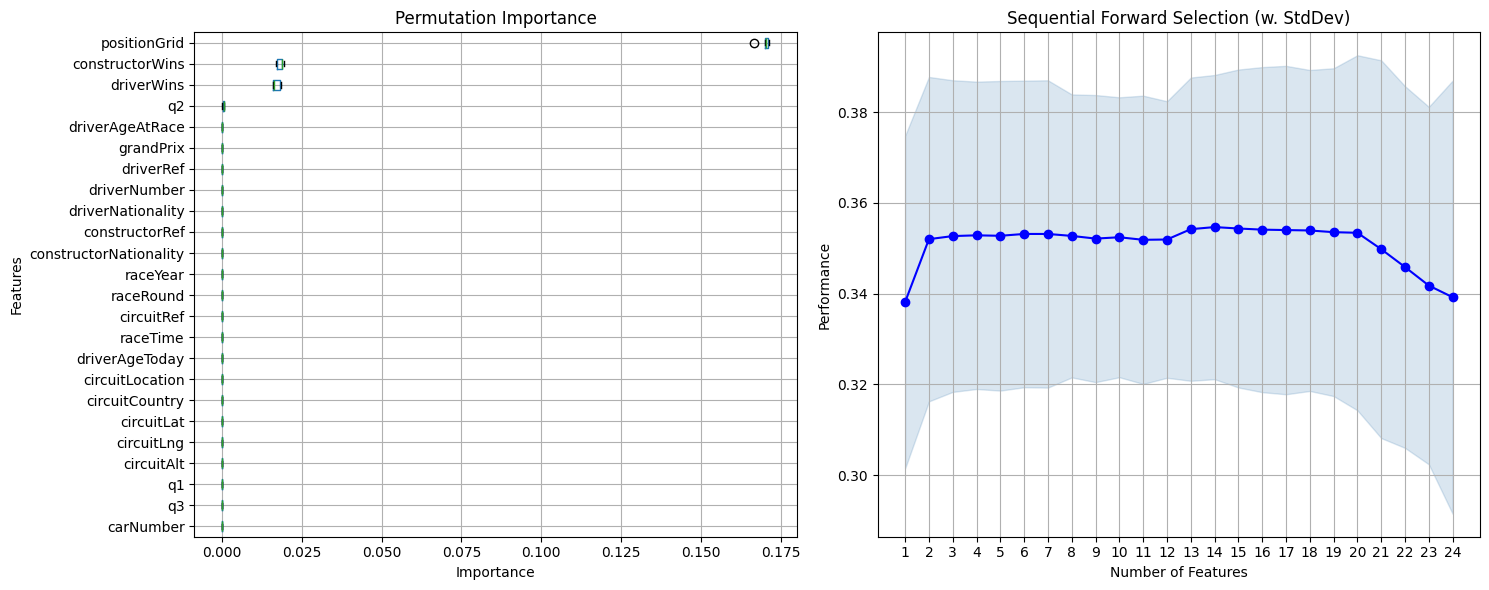

In [70]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=4, splitter="best")
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(tree, scoring)

PI: 0.352 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 17, 18, 19, 20, 21, 22, 23)
	== ('carNumber', 'circuitLat', 'circuitLng', 'circuitRef', 'constructorNationality',
	'constructorRef', 'constructorWins', 'driverAgeAtRace', 'driverAgeToday',
	'driverNationality', 'driverNumber', 'driverRef', 'driverWins', 'positionGrid', 'q1',
	'q2', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.368 with (1, 6, 9, 17, 18) == ('positionGrid', 'constructorNationality',
	'grandPrix', 'driverWins', 'constructorWins')
GA: 0.354 with (0, 1, 3, 4, 5, 12, 13, 15, 16, 17, 19, 21) == ('carNumber',
	'positionGrid', 'driverNumber', 'driverNationality', 'constructorRef',
	'circuitLocation', 'circuitCountry', 'circuitLng', 'circuitAlt', 'driverWins', 'q1',
	'q3')


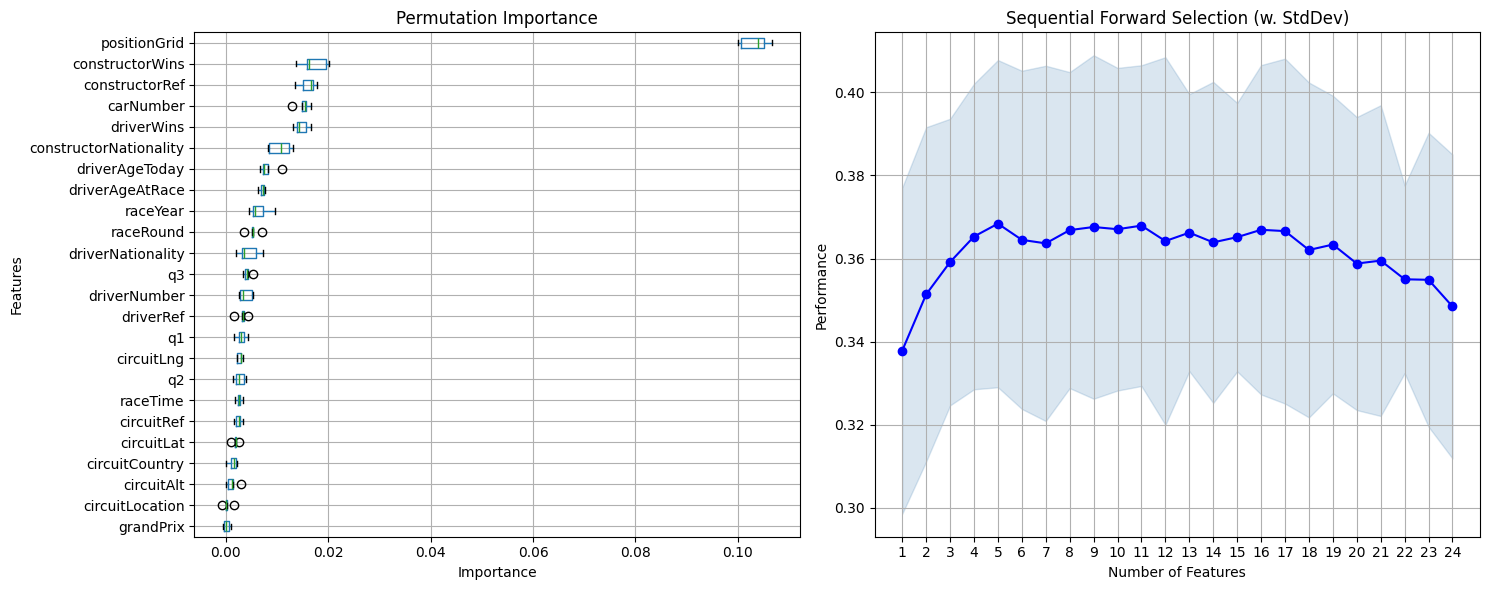

In [71]:
random_forest = RandomForestClassifier(criterion="gini", max_depth=5, n_estimators=200)
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(random_forest, scoring)

PI: 0.359 with (0, 1, 2, 5, 7, 8, 14, 16, 17, 18, 22) == ('carNumber', 'circuitAlt',
	'circuitLat', 'constructorRef', 'constructorWins', 'driverAgeToday', 'driverRef',
	'driverWins', 'positionGrid', 'raceRound', 'raceYear')
SFS: 0.369 with (1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 22, 23) ==
	('positionGrid', 'driverRef', 'driverNumber', 'driverNationality',
	'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'raceTime',
	'circuitLocation', 'circuitCountry', 'circuitLng', 'circuitAlt', 'driverWins',
	'constructorWins', 'driverAgeToday', 'driverAgeAtRace')
GA: 0.366 with (1, 2, 6, 9, 16, 17, 18, 19, 23) == ('positionGrid', 'driverRef',
	'constructorNationality', 'grandPrix', 'circuitAlt', 'driverWins', 'constructorWins',
	'q1', 'driverAgeAtRace')


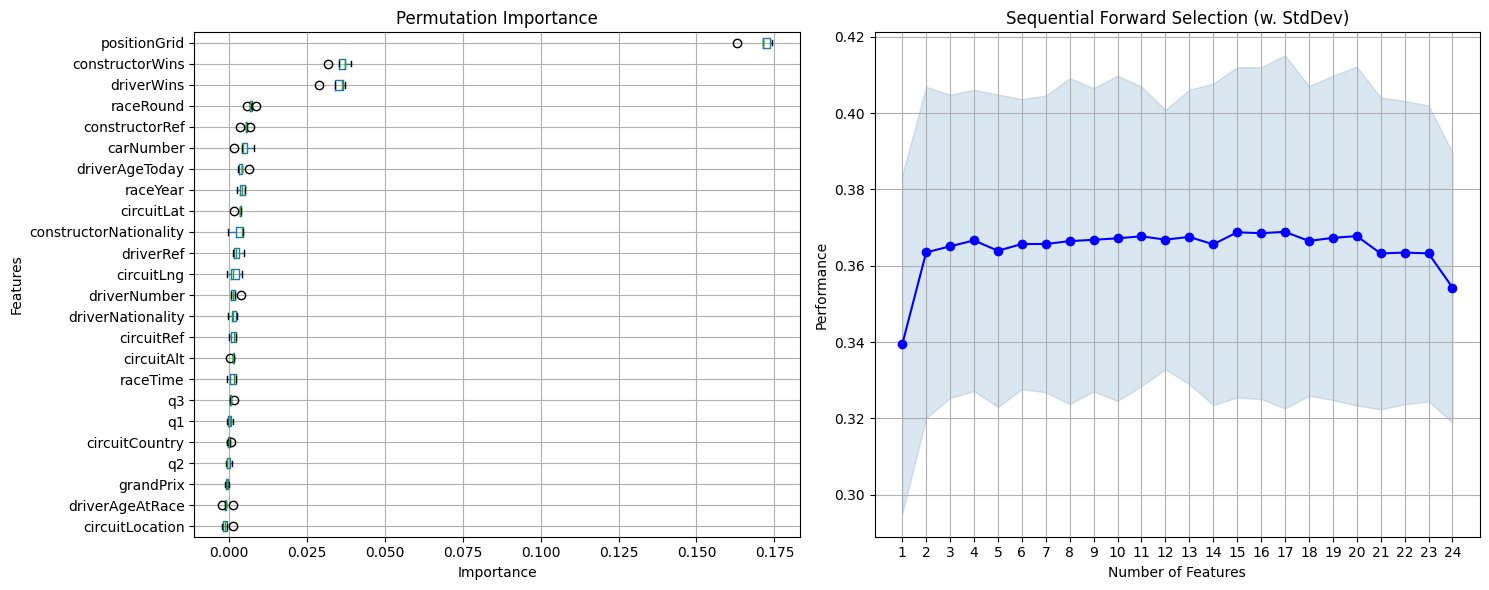

In [72]:
nn = MLPClassifier(activation="logistic", hidden_layer_sizes=(50, 25))
scoring = make_scorer(balanced_accuracy_1interval_score)
model_selection(nn, scoring)

Therefore, the selection for each algorithm are as follows

- KNeighborsClassifier: 0.347 with ('positionGrid', 'constructorRef', 'driverWins')
- DecisionTreeClassifier: 0.355 with ('positionGrid', 'driverNationality', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitLocation', 'circuitCountry', 'circuitLat', 'driverWins', 'q1', 'q2', 'q3')
- RandomForestClassifier: 0.369 with ('positionGrid', 'driverRef', 'driverNationality', 'constructorNationality', 'grandPrix', 'circuitRef', 'driverWins', 'constructorWins', 'q1')
- MLPClassifier: 0.370 with ('positionGrid', 'driverNationality', 'circuitRef', 'circuitCountry', 'circuitLat', 'driverWins', 'driverAgeToday', 'driverAgeAtRace')

We continue with the selection of the model that predicts the podium


In [73]:
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

PI: 0.726 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 22, 23) == ('carNumber', 'circuitAlt', 'circuitCountry', 'circuitLat',
	'circuitLng', 'circuitLocation', 'circuitRef', 'constructorNationality',
	'constructorRef', 'constructorWins', 'driverAgeAtRace', 'driverAgeToday',
	'driverNationality', 'driverNumber', 'driverRef', 'driverWins', 'grandPrix',
	'positionGrid', 'q1', 'q2', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.786 with (0, 1, 3, 4, 5, 7, 17) == ('carNumber', 'positionGrid', 'driverNumber',
	'driverNationality', 'constructorRef', 'raceYear', 'driverWins')
GA: 0.759 with (1, 2, 3, 4, 5, 8, 12, 17, 18, 22, 23) == ('positionGrid', 'driverRef',
	'driverNumber', 'driverNationality', 'constructorRef', 'raceRound', 'circuitLocation',
	'driverWins', 'constructorWins', 'driverAgeToday', 'driverAgeAtRace')


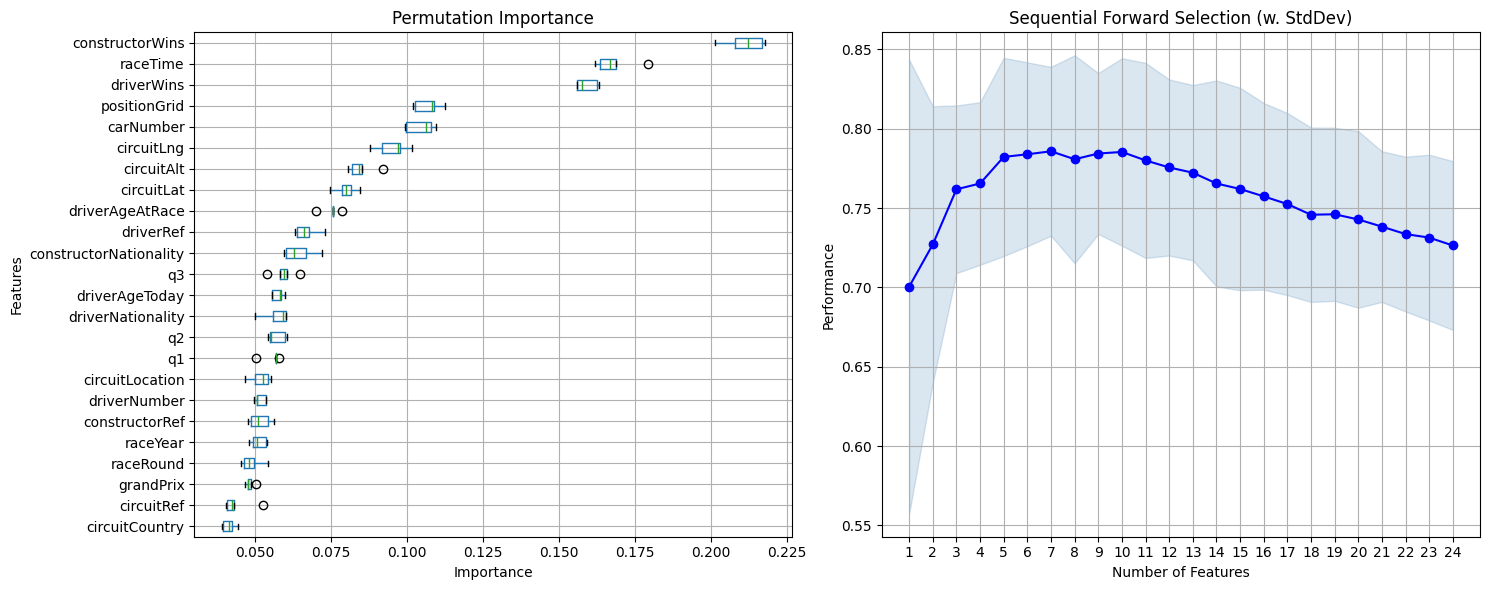

In [74]:
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine", weights="distance")
scoring = make_scorer(balanced_accuracy_score)
model_selection(knn, scoring)

PI: 0.780 with (1, 5, 17) == ('constructorRef', 'driverWins', 'positionGrid')
SFS: 0.799 with (0, 1, 2, 3, 5, 8, 9) == ('carNumber', 'positionGrid', 'driverRef',
	'driverNumber', 'constructorRef', 'raceRound', 'grandPrix')
GA: 0.788 with (0, 1, 3, 4, 5, 7, 9, 15, 16, 17, 19, 20, 21) == ('carNumber',
	'positionGrid', 'driverNumber', 'driverNationality', 'constructorRef', 'raceYear',
	'grandPrix', 'circuitLng', 'circuitAlt', 'driverWins', 'q1', 'q2', 'q3')


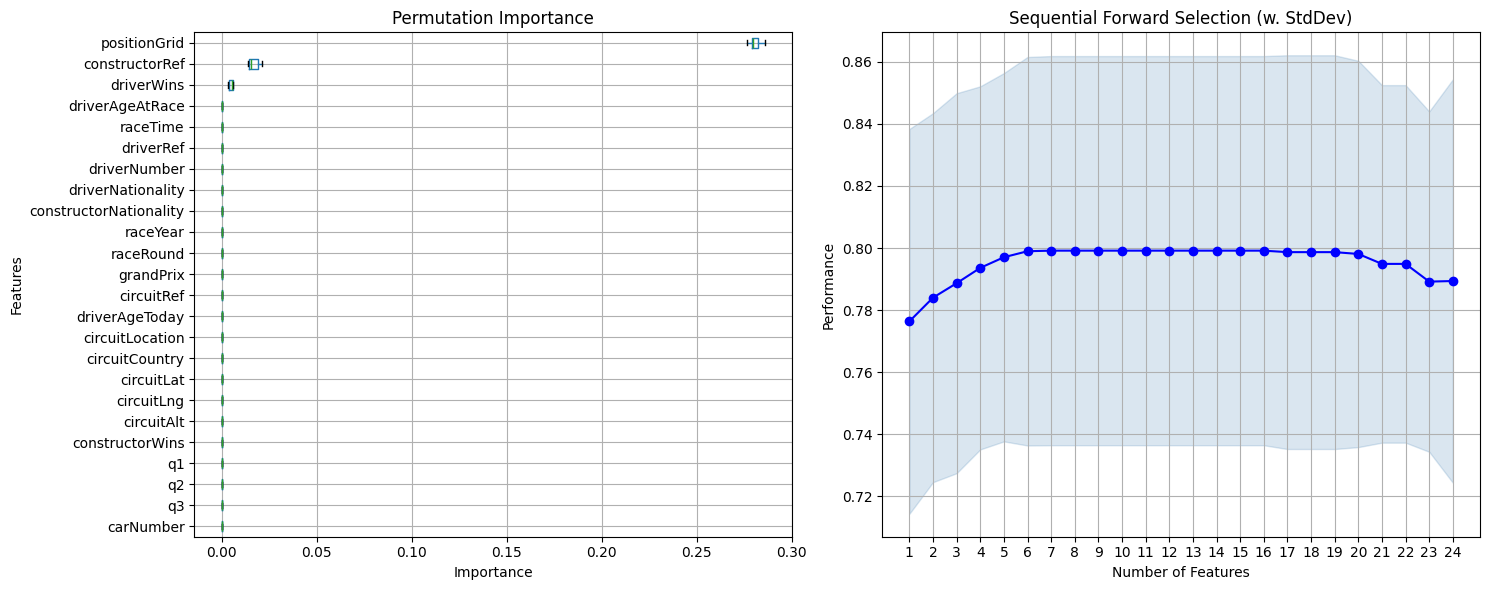

In [75]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=3, splitter="best")
scoring = make_scorer(balanced_accuracy_score)
model_selection(tree, scoring)

PI: 0.770 with (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
	20, 21, 22, 23) == ('carNumber', 'circuitAlt', 'circuitCountry', 'circuitLat',
	'circuitLng', 'circuitLocation', 'circuitRef', 'constructorNationality',
	'constructorRef', 'constructorWins', 'driverAgeAtRace', 'driverAgeToday',
	'driverNationality', 'driverNumber', 'driverRef', 'driverWins', 'grandPrix',
	'positionGrid', 'q1', 'q2', 'q3', 'raceRound', 'raceTime', 'raceYear')
SFS: 0.795 with (0, 1, 3, 4, 5, 17, 18) == ('carNumber', 'positionGrid', 'driverNumber',
	'driverNationality', 'constructorRef', 'driverWins', 'constructorWins')
GA: 0.790 with (1, 4, 5, 6, 7, 16, 17) == ('positionGrid', 'driverNationality',
	'constructorRef', 'constructorNationality', 'raceYear', 'circuitAlt', 'driverWins')


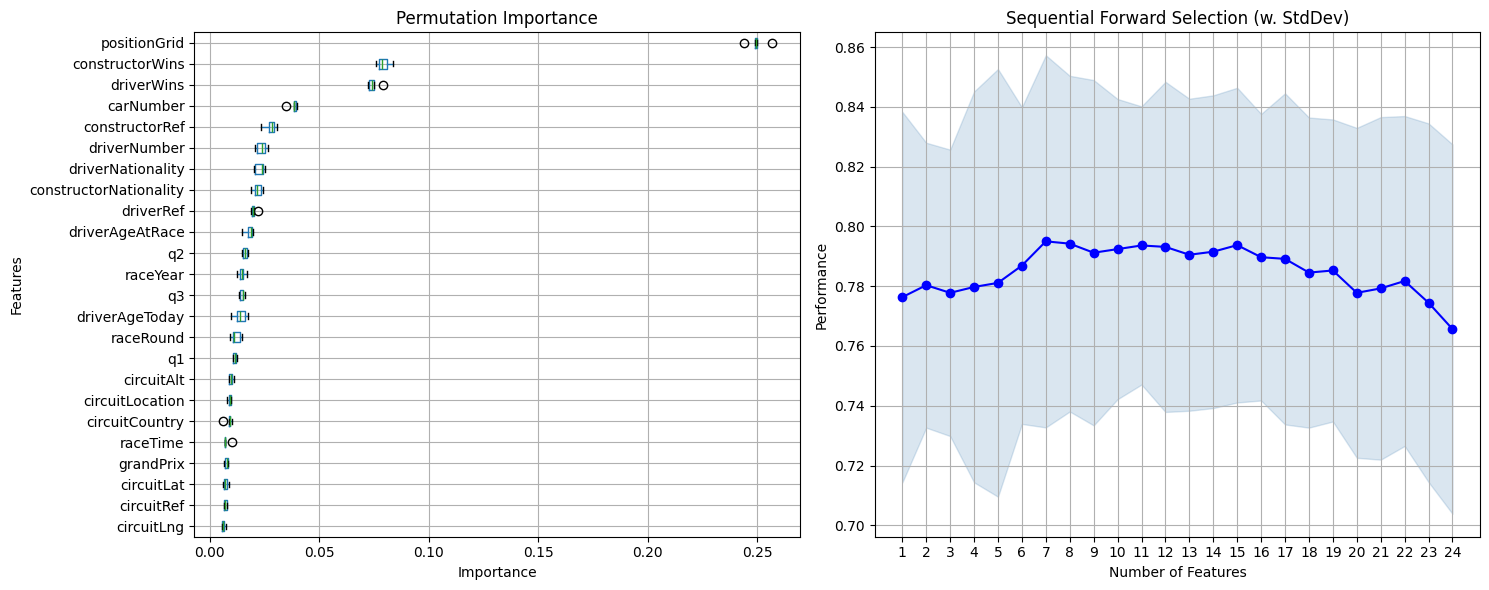

In [76]:
random_forest = RandomForestClassifier(criterion="gini", max_depth=10, n_estimators=200)
scoring = make_scorer(balanced_accuracy_score)
model_selection(random_forest, scoring)

PI: 0.789 with (1, 5, 6, 8, 17) == ('constructorNationality', 'constructorRef',
	'driverWins', 'positionGrid', 'raceRound')
SFS: 0.817 with (0, 1, 7, 8, 9, 11, 12, 13, 15, 16, 17, 20, 21, 22, 23) == ('carNumber',
	'positionGrid', 'raceYear', 'raceRound', 'grandPrix', 'circuitRef', 'circuitLocation',
	'circuitCountry', 'circuitLng', 'circuitAlt', 'driverWins', 'q2', 'q3',
	'driverAgeToday', 'driverAgeAtRace')
GA: 0.814 with (0, 1, 3, 7, 9, 12, 13, 14, 15, 17, 21, 22) == ('carNumber',
	'positionGrid', 'driverNumber', 'raceYear', 'grandPrix', 'circuitLocation',
	'circuitCountry', 'circuitLat', 'circuitLng', 'driverWins', 'q3', 'driverAgeToday')


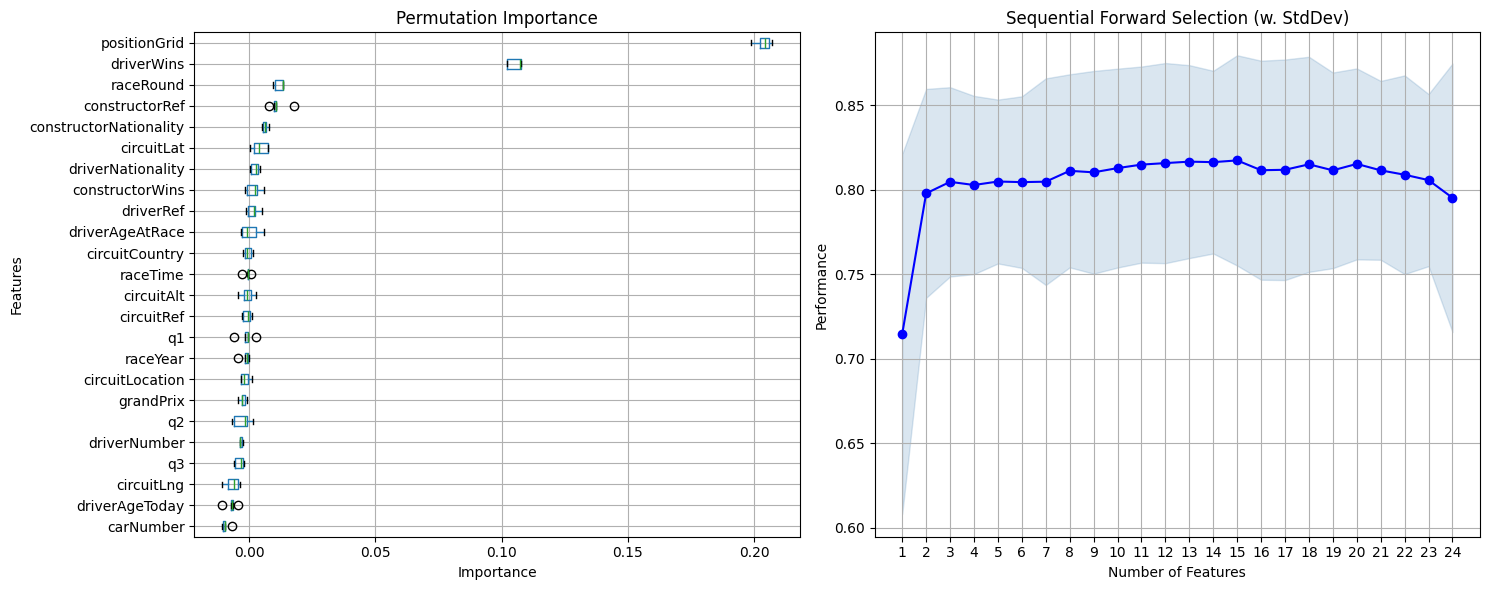

In [77]:
nn = MLPClassifier(activation="logistic", hidden_layer_sizes=(50, 20, 5))
scoring = make_scorer(balanced_accuracy_score)
model_selection(nn, scoring)

Therefore, the selection for each algorithm are as follows

- KNeighborsClassifier: 0.785 with ('carNumber', 'positionGrid', 'driverNumber', 'constructorRef', 'raceYear', 'driverWins')
- DecisionTreeClassifier: 0.794 with ('carNumber', 'positionGrid', 'driverRef', 'constructorRef', 'constructorNationality', 'raceYear', 'raceRound', 'grandPrix', 'raceTime', 'circuitRef', 'circuitLocation', 'circuitCountry', 'circuitLat', 'circuitLng', 'circuitAlt', 'driverWins', 'constructorWins', 'q1', 'q2', 'q3')
- RandomForestClassifier: 0.794 with ('positionGrid', 'driverRef', 'raceYear', 'circuitLng', 'driverWins', 'q1')
- MLPClassifier: 0.815 with ('carNumber', 'positionGrid', 'driverRef', 'driverNumber', 'driverNationality', 'raceYear', 'raceRound', 'circuitRef', 'circuitLocation', 'circuitLat', 'circuitAlt', 'driverWins', 'q1', 'q2', 'q3', 'driverAgeToday', 'driverAgeAtRace')


## Advanced Hyperparameter Tuning


After feature selection, we proceed to advanced hyperparameter tuning. For this purpose, optuna, an automatic hyperparameter optimization software framework specially designed for machine learning, will be used.

We will also define an auxiliary function to help us make the tuning, as was done in previous sections.


In [78]:
def model_tuning(params, model, scoring):

    def objective(trial):
        params_trial = dict()
        for param in params:
            type = param[0]
            data = param[1]
            if type == "int":
                params_trial[data[0]] = trial.suggest_int(*data)
            elif type == "categorical":
                params_trial[data[0]] = trial.suggest_categorical(*data)
            elif type == "mlp":
                layers = []
                n_layers = trial.suggest_int("n_layers", 1, data[1])
                for i in range(n_layers):
                    layers.append(trial.suggest_int(f"n_units_{i}", 1, data[2]))
                params_trial[data[0]] = tuple(layers)

        score = cross_val_score(
            model(**params_trial),
            X_selected,
            y,
            n_jobs=-1,
            cv=tscv,
            scoring=scoring,
        )

        return sum(score) / len(score)

    study = create_study(direction="maximize")
    study.optimize(objective, n_trials=150, n_jobs=-1)

    output = "%s: %.3f with %s" % (
        model.__name__,
        study.best_trial.values[0],
        study.best_trial.params,
    )
    print("\n".join(textwrap.wrap(output, 88, subsequent_indent="\t")))
    plot_optimization_history(study, target_name="Performance")
    plt.show()

First we will do the tuning of the model that predicts the final position of each driver at a +-1 interval.


In [79]:
y = df["positionFinal"]

KNeighborsClassifier: 0.349 with {'n_neighbors': 99, 'metric': 'manhattan', 'weights':
	'uniform'}


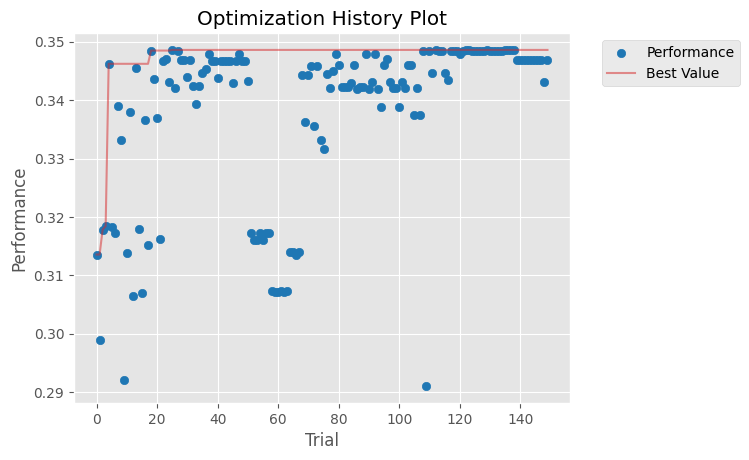

In [80]:
X_selected = X[
    [
        "positionGrid",
        "constructorRef",
        "driverWins",
    ]
]
params = [
    ("int", ("n_neighbors", 1, 101)),
    ("categorical", ("metric", ["cosine", "euclidean", "manhattan"])),
    ("categorical", ("weights", ["distance", "uniform"])),
]
model = KNeighborsClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, scoring)

DecisionTreeClassifier: 0.355 with {'max_depth': 4, 'criterion': 'gini', 'splitter':
	'best'}


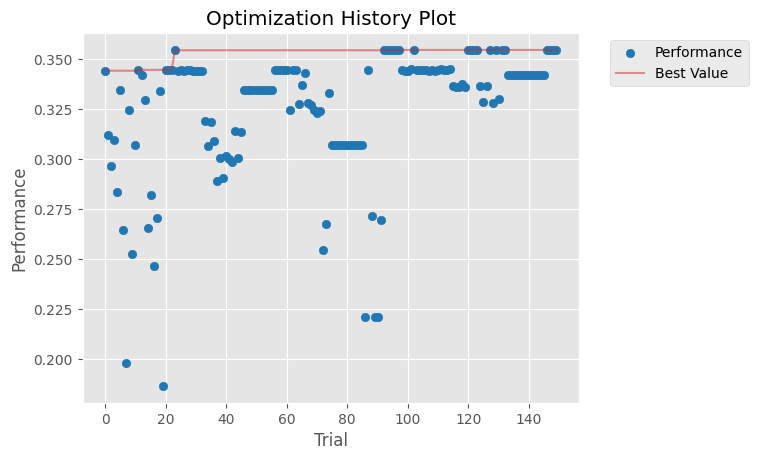

In [81]:
X_selected = X[
    [
        "positionGrid",
        "driverNationality",
        "constructorNationality",
        "raceYear",
        "raceRound",
        "grandPrix",
        "raceTime",
        "circuitLocation",
        "circuitCountry",
        "circuitLat",
        "driverWins",
        "q1",
        "q2",
        "q3",
    ]
]
params = [
    ("int", ("max_depth", 1, 15)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
    ("categorical", ("splitter", ["best", "random"])),
]
model = DecisionTreeClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, scoring)

RandomForestClassifier: 0.369 with {'max_depth': 6, 'n_estimators': 143, 'criterion':
	'gini'}


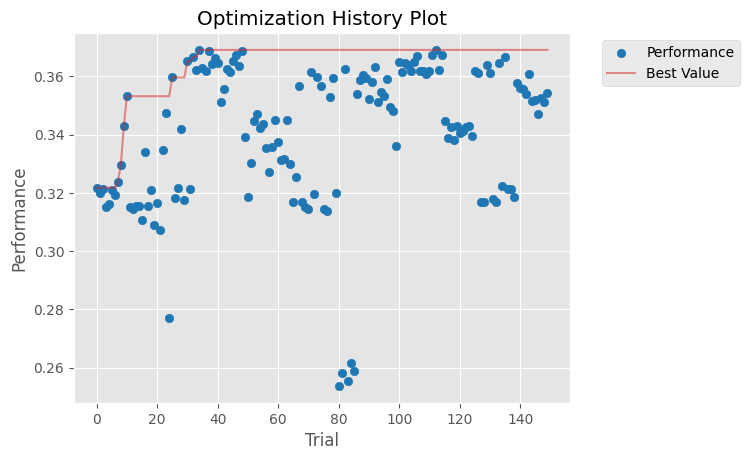

In [82]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "driverNationality",
        "constructorNationality",
        "grandPrix",
        "circuitRef",
        "driverWins",
        "constructorWins",
        "q1",
    ]
]
params = [
    ("int", ("max_depth", 1, 50)),
    ("int", ("n_estimators", 1, 500)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
]
model = RandomForestClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, scoring)

MLPClassifier: 0.369 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 47,
	'n_units_1': 26, 'n_units_2': 31}


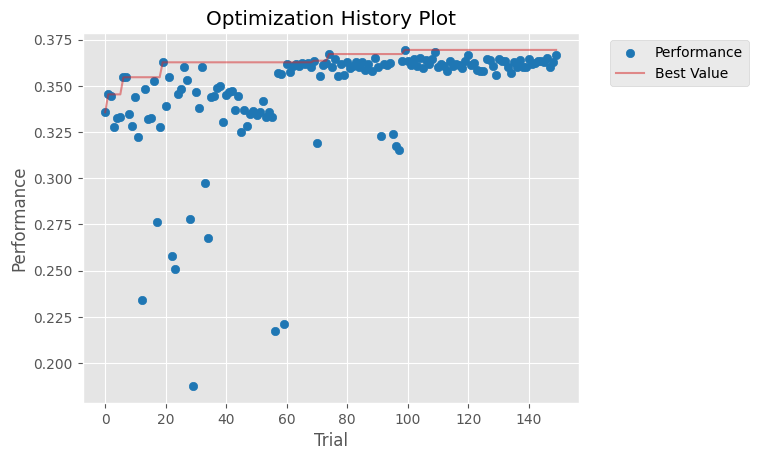

In [83]:
X_selected = X[
    [
        "positionGrid",
        "driverNationality",
        "circuitRef",
        "circuitCountry",
        "circuitLat",
        "driverWins",
        "driverAgeToday",
        "driverAgeAtRace",
    ]
]
params = [
    ("categorical", ("activation", ["tanh", "logistic", "identity", "relu"])),
    ("mlp", ("hidden_layer_sizes", 4, 50)),
]
model = MLPClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, scoring)

Therefore, the tuning for each algorithm are as follows

- KNeighborsClassifier: 0.349 with {'n_neighbors': 99, 'metric': 'manhattan', 'weights': 'uniform'}
- DecisionTreeClassifier: 0.355 with {'max_depth': 4, 'criterion': 'gini', 'splitter': 'best'}
- RandomForestClassifier: RandomForestClassifier: 0.369 with {'max_depth': 6, 'n_estimators': 143, 'criterion': 'gini'}
- MLPClassifier: 0.369 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 47, 'n_units_1': 26, 'n_units_2': 31}

We continue with the tuning of the model that predicts the podium


In [84]:
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

KNeighborsClassifier: 0.787 with {'n_neighbors': 53, 'metric': 'cosine', 'weights':
	'distance'}


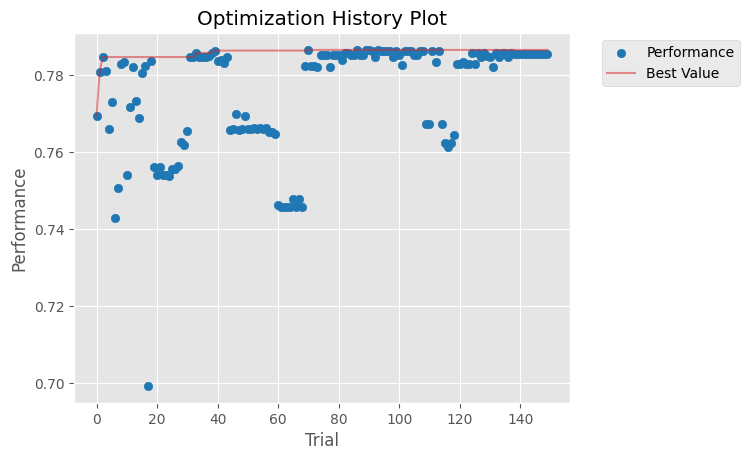

In [85]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverNumber",
        "constructorRef",
        "raceYear",
        "driverWins",
    ]
]
params = [
    ("int", ("n_neighbors", 1, 101)),
    ("categorical", ("metric", ["cosine", "euclidean", "manhattan"])),
    ("categorical", ("weights", ["distance", "uniform"])),
]
model = KNeighborsClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, scoring)

DecisionTreeClassifier: 0.794 with {'max_depth': 3, 'criterion': 'gini', 'splitter':
	'best'}


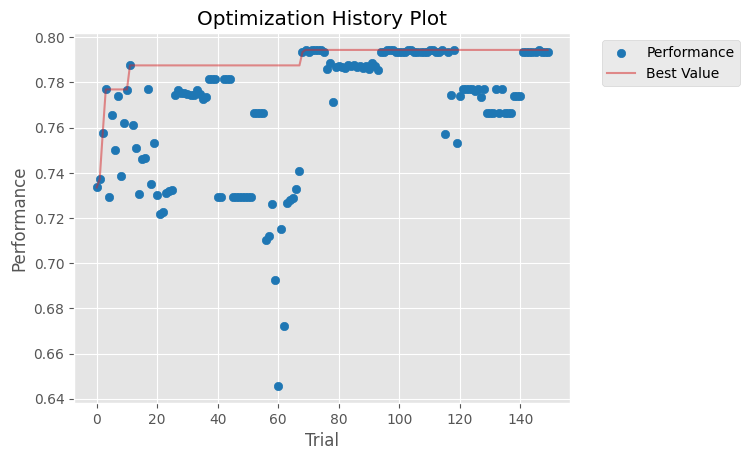

In [86]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "constructorRef",
        "constructorNationality",
        "raceYear",
        "raceRound",
        "grandPrix",
        "raceTime",
        "circuitRef",
        "circuitLocation",
        "circuitCountry",
        "circuitLat",
        "circuitLng",
        "circuitAlt",
        "driverWins",
        "constructorWins",
        "q1",
        "q2",
        "q3",
    ]
]
params = [
    ("int", ("max_depth", 1, 15)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
    ("categorical", ("splitter", ["best", "random"])),
]
model = DecisionTreeClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, scoring)

RandomForestClassifier: 0.793 with {'max_depth': 8, 'n_estimators': 440, 'criterion':
	'gini'}


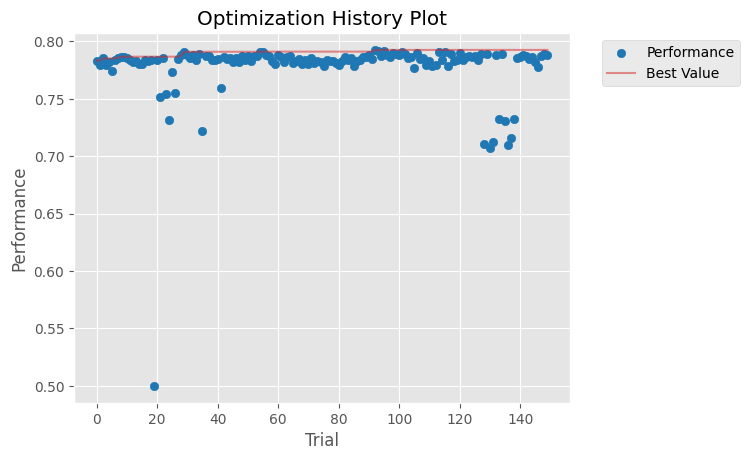

In [87]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "raceYear",
        "circuitLng",
        "driverWins",
        "q1",
    ]
]
params = [
    ("int", ("max_depth", 1, 50)),
    ("int", ("n_estimators", 1, 500)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
]
model = RandomForestClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, scoring)

MLPClassifier: 0.814 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 63,
	'n_units_1': 30, 'n_units_2': 7}


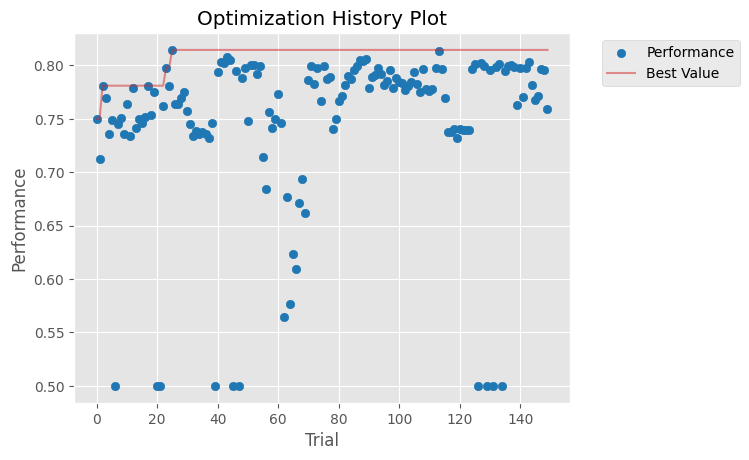

In [88]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "driverNumber",
        "driverNationality",
        "raceYear",
        "raceRound",
        "circuitRef",
        "circuitLocation",
        "circuitLat",
        "circuitAlt",
        "driverWins",
        "q1",
        "q2",
        "q3",
        "driverAgeToday",
        "driverAgeAtRace",
    ]
]
params = [
    ("categorical", ("activation", ["tanh", "logistic", "relu", "identity"])),
    ("mlp", ("hidden_layer_sizes", 10, 100)),
]
model = MLPClassifier
scoring = make_scorer(balanced_accuracy_score)
model_tuning(params, model, scoring)

Therefore, the tuning for each algorithm are as follows

- KNeighborsClassifier: 0.787 with {'n_neighbors': 53, 'metric': 'cosine', 'weights': 'distance'}
- DecisionTreeClassifier: 0.794 with {'max_depth': 3, 'criterion': 'gini', 'splitter': 'best'}
- RandomForestClassifier: 0.793 with {'max_depth': 8, 'n_estimators': 440, 'criterion': 'gini'}
- MLPClassifier: 0.814 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 63, 'n_units_1': 30, 'n_units_2': 7}


## adding data ::: unfinished


In [89]:
calc_exp = lambda x: [
    sum(df.loc[:i, "driverRef"] == r["driverRef"]) for i, r in x.iterrows()
]

df["driverExp"] = calc_exp(df)

In [90]:
mnm = min(df["driverExp"])
rg = max(df["driverExp"]) - mnm
arr = (df["driverExp"] - mnm) / rg
rg2 = 99 - 50
normalized = (arr * rg2) + 50

df["driverExp"] = round(normalized)

In [91]:
driver_ratings_df = pd.read_csv("./data/driver_ratings_ea.csv")

In [92]:
for year, driver, exp, rac, awa, pac, ovr in driver_ratings_df.itertuples(index=False):
    mask = (df["raceYear"] == int(year)) & (
        df["driverRef"].apply(lambda x: x in driver)
    )

    df.loc[mask, "driverExp"] = exp
    df.loc[mask, "driverRac"] = rac
    df.loc[mask, "driverAwa"] = awa
    df.loc[mask, "driverPac"] = pac
    df.loc[mask, "driverOvr"] = ovr

In [93]:
n_features = 5
n_neighbors = 5

driver_exp = dict()

for e in range(50, 100):
    close_exp = sorted(driver_ratings_df.to_numpy(), key=lambda x: np.abs(x[2] - e))[
        :n_neighbors
    ]
    avg_ratings = []
    for i in range(2, n_features + 2):
        ratings = []
        for j in range(n_neighbors):
            ratings.append(close_exp[j][i])
        avg_ratings.append(round(sum(ratings) / n_neighbors))
    driver_exp[e] = avg_ratings


m = df["driverOvr"].isnull()
p = "driverExp"
df["driverExp"] = df["driverExp"].fillna(df.loc[m, p].apply(lambda x: driver_exp[x][0]))
df["driverRac"] = df["driverRac"].fillna(df.loc[m, p].apply(lambda x: driver_exp[x][1]))
df["driverAwa"] = df["driverAwa"].fillna(df.loc[m, p].apply(lambda x: driver_exp[x][2]))
df["driverPac"] = df["driverPac"].fillna(df.loc[m, p].apply(lambda x: driver_exp[x][3]))
df["driverOvr"] = df["driverOvr"].fillna(df.loc[m, p].apply(lambda x: driver_exp[x][4]))

In [94]:
X = df.drop(
    [
        "positionFinal",
        "pointsDriverEarned",
        "lapsCompleted",
        "timeTakenInMillisec",
        "fastestLap",
        "fastestLapRank",
        "fastestLapTime",
        "maxSpeed",
        "driverStatus",
        "pointsConstructorEarned",
        "constructorPosition",
    ],
    axis=1,
)

enc = LabelEncoder()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = enc.fit_transform(X[c])

In [95]:
labels = np.array(["not_podium", "podium"])
podiums = df[df["positionFinal"].isin([1, 2, 3])][
    ["raceYear", "raceRound", "driverRef"]
]
podiums = podiums.groupby(by=["raceYear", "raceRound"]).agg({"driverRef": ",".join})
y = df.merge(podiums, how="left", on=["raceYear", "raceRound"], suffixes=("", "Podium"))
y = y.apply(lambda x: x["driverRef"] in x["driverRefPodium"], axis=1)

DecisionTreeClassifier(max_depth=3):
CV with make_scorer(balanced_accuracy_score): 0.7856416175438471


CV with neg_mean_absolute_error: nan
              precision    recall  f1-score   support

  not_podium       0.94      0.95      0.94      4545
      podium       0.66      0.62      0.64       756

    accuracy                           0.90      5301
   macro avg       0.80      0.78      0.79      5301
weighted avg       0.90      0.90      0.90      5301



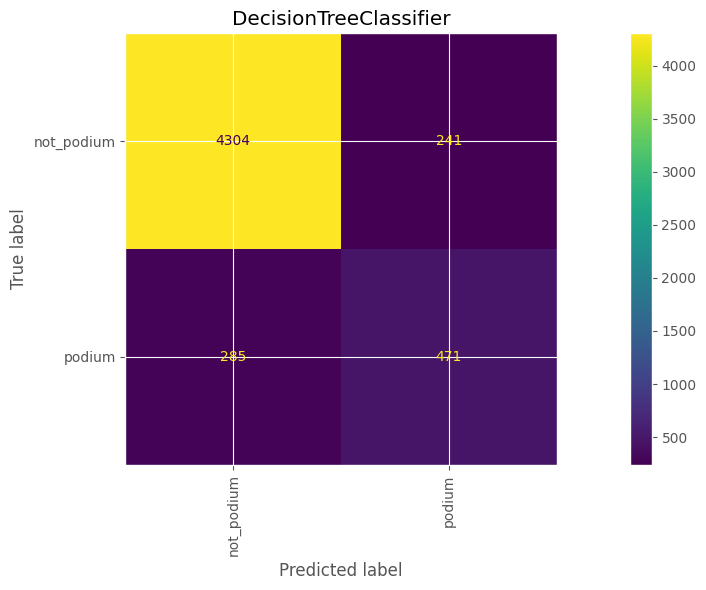

|--- positionGrid <= 3.50
|   |--- driverRef <= 69.50
|   |   |--- driverWins <= 0.50
|   |   |   |--- class: podium
|   |   |--- driverWins >  0.50
|   |   |   |--- class: podium
|   |--- driverRef >  69.50
|   |   |--- circuitRef <= 12.50
|   |   |   |--- class: not_podium
|   |   |--- circuitRef >  12.50
|   |   |   |--- class: podium
|--- positionGrid >  3.50
|   |--- constructorWins <= 3.50
|   |   |--- positionGrid <= 5.50
|   |   |   |--- class: not_podium
|   |   |--- positionGrid >  5.50
|   |   |   |--- class: not_podium
|   |--- constructorWins >  3.50
|   |   |--- driverNationality <= 10.50
|   |   |   |--- class: podium
|   |   |--- driverNationality >  10.50
|   |   |   |--- class: not_podium



In [96]:
tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
model_test((tree,), X, y, tscv, labels=labels)
print(export_text(tree, feature_names=X.columns, class_names=labels))

TODO:

- 1.- Add more attributes (https://www.ea.com/es-es/games/f1/driver-ratings)???
- 2.- Outliers
